In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

In [2]:
temp = np.array([5,2])
temp**2

array([25,  4])

In [3]:
df2 = pd.read_csv('clean_new_well_data_fixed.csv')

In [4]:
df = pd.read_csv('AASG_Thermed_AllTempsThicksConds.csv',low_memory=False)

In [5]:
def outlierDrop(df,df_toCheck,std_cut_off):
    init_len = df.shape[0]
    for i in df_toCheck:
        mean = df[i].mean()
        std = df[i].std()
        cut_off = std * std_cut_off
        lower, upper =mean - cut_off, mean + cut_off
        df = df[(df[i] < upper) & (df[i] > lower)]
    print("numbere of outliers removed: ", init_len - df.shape[0])
    return df
#df = outlierDrop(df,['CorrBHT', 'HeatFlow','MeasureDepth_m'],4)
df = outlierDrop(df,['HeatFlow'],3)
df = df[df['HeatFlow']>0]

numbere of outliers removed:  67


In [6]:
df.reset_index(inplace=True, drop=True)

In [7]:
df2

,id,depth,temp,lat,lon,corrtemp
0,4703502978,671.1696,23.648778,38.787043,-81.805252,26.034804
1,4703502978,671.3220,23.646333,38.787043,-81.805252,26.033353
2,4703502978,671.4744,23.643444,38.787043,-81.805252,26.031458
3,4703502978,671.6268,23.640278,38.787043,-81.805252,26.029285
4,4703502978,671.7792,23.636778,38.787043,-81.805252,26.026778
...,...,...,...,...,...,...
582743,4710300645,2021.9670,56.438889,39.678222,-80.823766,67.632114
582744,4710300645,2022.0432,56.444444,39.678222,-80.823766,67.638166
582745,4710300645,2022.1194,56.444444,39.678222,-80.823766,67.638663
582746,4710300645,2022.1956,56.444444,39.678222,-80.823766,67.639160


# Find Closest Points for Estimation with Phys Model

1. Get Random 100 points from df2

In [8]:
num_sample=10000
sampled_df2 = df2.sample(num_sample)

In [9]:
import math
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

In [10]:
# Round by 10 to later compare with T1~T500
sampled_df2.depth = np.round(sampled_df2.depth,decimals=-1).astype('int')

In [11]:
sampled_df2

,id,depth,temp,lat,lon,corrtemp
46230,4701900241,880,35.194444,38.113789,-80.984939,38.920901
169607,4705900811,1510,41.466667,37.572413,-81.844652,49.347069
304982,4707700099,1220,26.088889,39.267533,-79.561792,32.027206
434789,4706100370,670,25.322222,39.668611,-79.973694,27.699802
424605,4709100138,890,31.444444,39.338962,-80.177553,35.277222
...,...,...,...,...,...,...
556582,4709501963,1560,52.211111,39.518877,-81.018447,60.393086
567575,4710300645,870,24.288889,39.678222,-80.823766,27.946287
355526,4708300103,1320,56.611111,38.707282,-79.969042,63.243988
330733,4707700458,2280,64.250000,39.523952,-79.615534,77.115038


2. Find closest point in lat and lon

In [12]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(np.transpose(np.array([df.LatDegree, df.LongDegree])))
pred_indices = neigh.kneighbors(np.transpose(np.array([sampled_df2.lat,sampled_df2.lon])),return_distance=False)

In [13]:
sampled_df2.insert(6, 'closest',pred_indices)

In [14]:
sampled_df2.reset_index(inplace=True)

In [15]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest
0,46230,4701900241,880,35.194444,38.113789,-80.984939,38.920901,17296
1,169607,4705900811,1510,41.466667,37.572413,-81.844652,49.347069,20168
2,304982,4707700099,1220,26.088889,39.267533,-79.561792,32.027206,19021
3,434789,4706100370,670,25.322222,39.668611,-79.973694,27.699802,18967
4,424605,4709100138,890,31.444444,39.338962,-80.177553,35.277222,19578
...,...,...,...,...,...,...,...,...
9995,556582,4709501963,1560,52.211111,39.518877,-81.018447,60.393086,19701
9996,567575,4710300645,870,24.288889,39.678222,-80.823766,27.946287,20065
9997,355526,4708300103,1320,56.611111,38.707282,-79.969042,63.243988,19185
9998,330733,4707700458,2280,64.250000,39.523952,-79.615534,77.115038,19054


In [16]:
predicted_values_by_physics_model = []
for i in range(0, num_sample):
    curr_depth = sampled_df2.depth[i]
    curr_row = df.loc[sampled_df2.closest[i]] # obtain the row
    t_string = 'T'+str(int(curr_depth/10))
    predicted_value = curr_row[t_string]
    predicted_values_by_physics_model.append(predicted_value)

In [17]:
predicted_values_by_physics_model = np.array(predicted_values_by_physics_model)

In [18]:
sampled_df2.insert(8, 'physics_pred', predicted_values_by_physics_model)

In [19]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest,physics_pred
0,46230,4701900241,880,35.194444,38.113789,-80.984939,38.920901,17296,26.8
1,169607,4705900811,1510,41.466667,37.572413,-81.844652,49.347069,20168,51.0
2,304982,4707700099,1220,26.088889,39.267533,-79.561792,32.027206,19021,54.9
3,434789,4706100370,670,25.322222,39.668611,-79.973694,27.699802,18967,24.7
4,424605,4709100138,890,31.444444,39.338962,-80.177553,35.277222,19578,26.3
...,...,...,...,...,...,...,...,...,...
9995,556582,4709501963,1560,52.211111,39.518877,-81.018447,60.393086,19701,61.2
9996,567575,4710300645,870,24.288889,39.678222,-80.823766,27.946287,20065,27.2
9997,355526,4708300103,1320,56.611111,38.707282,-79.969042,63.243988,19185,36.7
9998,330733,4707700458,2280,64.250000,39.523952,-79.615534,77.115038,19054,77.9


# Add Geological Information

- Predict: Geological information of sampled_df2, cond1*thick1 + ...

In [20]:
lat_to_interpolate = sampled_df2.lat
lon_to_interpolate = sampled_df2.lon

In [21]:
layers = df.iloc[:,52:101].values
conds = df.iloc[:,101:150].values
mult = np.multiply(layers,conds)
np.nan_to_num(mult, 0)
mult.shape

(20649, 49)

In [22]:
# Read optimal values
f = open("optim_result.out", "r")
lines = f.readlines()

In [23]:
optimal_neigh = []
optimal_width = []
for line in lines:
    optimal_neigh.append(line.split(',')[0][0])
    optimal_width.append(line.split(',')[1])
optimal_neigh = np.array(optimal_neigh).astype('int')
optimal_width = np.array(optimal_width).astype('float')

In [24]:
# Predict 49 layers information for each sampled_df2 lat and lon
from sklearn.neighbors import KNeighborsRegressor
predicted_mults = []
for i in range(0,49):
    def gaussian_kernel(distances):
                kernel_width = optimal_width[i]
                weights = np.exp(-(distances**2)/kernel_width)
                return weights
    knn = KNeighborsRegressor(n_neighbors=optimal_neigh[i],weights=gaussian_kernel)
    #knn = KNeighborsRegressor(n_neighbors=1,weights=gaussian_kernel)
    knn.fit(np.transpose(np.array([df.LatDegree, df.LongDegree])), mult[:,i])
    y_pred = knn.predict(np.transpose(np.array([sampled_df2.lat, sampled_df2.lon])))
    predicted_mults.append(y_pred)

In [25]:
predicted_mults = np.transpose(np.array(predicted_mults))

In [26]:
# Predict T_SURF
def gaussian_kernel(distances):
            kernel_width = 2.598
            weights = np.exp(-(distances**2)/kernel_width)
            return weights
knn = KNeighborsRegressor(n_neighbors=1,weights=gaussian_kernel)
knn.fit(np.transpose(np.array([df.LatDegree, df.LongDegree])), df.SurfTemp)
predicted_tsurf = knn.predict(np.transpose(np.array([sampled_df2.lat, sampled_df2.lon])))

# Prediction with XGB

In [27]:
X_train = np.transpose(np.array([df.LatDegree,
                                df.LongDegree,
                                df.MeasureDepth_m,
                                df.SurfTemp]))
y_train = df.CorrBHT.values
X_train = np.concatenate((X_train, mult),axis=1)

In [28]:
X_test = np.transpose(np.array([sampled_df2.lat,
                               sampled_df2.lon,
                               sampled_df2.depth,
                               predicted_tsurf]))
X_test = np.concatenate((X_test, predicted_mults),axis=1)

In [29]:
import pickle
gbm = pickle.load(open('finalized_model_XGB.sav', 'rb'))
y_pred = gbm.predict(X_test)

In [30]:
sampled_df2.insert(9, 'gbm_pred', y_pred)

In [31]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest,physics_pred,gbm_pred
0,46230,4701900241,880,35.194444,38.113789,-80.984939,38.920901,17296,26.8,34.131718
1,169607,4705900811,1510,41.466667,37.572413,-81.844652,49.347069,20168,51.0,50.678089
2,304982,4707700099,1220,26.088889,39.267533,-79.561792,32.027206,19021,54.9,51.897446
3,434789,4706100370,670,25.322222,39.668611,-79.973694,27.699802,18967,24.7,27.010910
4,424605,4709100138,890,31.444444,39.338962,-80.177553,35.277222,19578,26.3,30.527145
...,...,...,...,...,...,...,...,...,...,...
9995,556582,4709501963,1560,52.211111,39.518877,-81.018447,60.393086,19701,61.2,52.097004
9996,567575,4710300645,870,24.288889,39.678222,-80.823766,27.946287,20065,27.2,25.087847
9997,355526,4708300103,1320,56.611111,38.707282,-79.969042,63.243988,19185,36.7,39.591377
9998,330733,4707700458,2280,64.250000,39.523952,-79.615534,77.115038,19054,77.9,77.103699


# Prediction with DNN

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import sklearn.metrics as m
def baseline_model():
    # create model
    # Sequential model is for just building up each layer
    model = Sequential()
    # Kernel initializer sets up the distribution for the random parameters
    model.add(Dense(50, #kernel_regularizer=regularizers.l2(0.1),
                    kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, #kernel_regularizer=regularizers.l2(0.1),
                    kernel_initializer='normal', activation='relu'))    
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


model = KerasRegressor(build_fn=baseline_model, epochs=150, batch_size=50, verbose=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [33]:
sampled_df2.insert(10, 'dnn_pred', y_pred)

In [34]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest,physics_pred,gbm_pred,dnn_pred
0,46230,4701900241,880,35.194444,38.113789,-80.984939,38.920901,17296,26.8,34.131718,33.211952
1,169607,4705900811,1510,41.466667,37.572413,-81.844652,49.347069,20168,51.0,50.678089,50.092697
2,304982,4707700099,1220,26.088889,39.267533,-79.561792,32.027206,19021,54.9,51.897446,40.864529
3,434789,4706100370,670,25.322222,39.668611,-79.973694,27.699802,18967,24.7,27.010910,26.585238
4,424605,4709100138,890,31.444444,39.338962,-80.177553,35.277222,19578,26.3,30.527145,30.975018
...,...,...,...,...,...,...,...,...,...,...,...
9995,556582,4709501963,1560,52.211111,39.518877,-81.018447,60.393086,19701,61.2,52.097004,51.712303
9996,567575,4710300645,870,24.288889,39.678222,-80.823766,27.946287,20065,27.2,25.087847,23.518005
9997,355526,4708300103,1320,56.611111,38.707282,-79.969042,63.243988,19185,36.7,39.591377,41.611328
9998,330733,4707700458,2280,64.250000,39.523952,-79.615534,77.115038,19054,77.9,77.103699,74.020546


In [35]:
print(X_train.shape, X_test.shape, y_train.shape)

(20649, 53) (10000, 53) (20649,)


In [36]:
X_train

array([[  38.46013 ,  -82.72102 ,  529.13    , ...,    0.      ,
           0.      ,    0.      ],
       [  38.4595  ,  -82.716841,  529.74    , ...,    0.      ,
           0.      ,    0.      ],
       [  38.454476,  -82.712581,  655.62    , ...,    0.      ,
           0.      ,    0.      ],
       ...,
       [  36.978792,  -82.221254, 1883.05    , ...,    0.      ,
           0.      ,    0.      ],
       [  37.266704,  -81.378057, 1505.71    , ...,  162.61245 ,
        1318.94295 ,  104.1656  ],
       [  42.47049 ,  -78.1599  , 2304.29    , ...,    0.      ,
           0.      ,    0.      ]])

In [37]:
df

,RowID,StateID,WellName,APINo,County,State,LatDegree,LongDegree,SRS,DrillerTotalDepth,...,T491,T492,T493,T494,T495,T496,T497,T498,T499,T500
0,610,KY604,,1.6019E+13,Boyd,KY,38.460130,-82.721020,NAD 83,1735,...,164.7,165.0,165.3,165.5,165.8,166.1,166.4,166.6,166.9,167.2
1,611,KY605,,1.6019E+13,Boyd,KY,38.459500,-82.716841,NAD 83,1738,...,156.4,156.7,156.9,157.2,157.4,157.7,157.9,158.2,158.5,158.7
2,612,KY606,,1.6019E+13,Boyd,KY,38.454476,-82.712581,NAD 83,2151,...,120.5,120.7,120.9,121.1,121.3,121.5,121.7,121.8,122.0,122.2
3,613,KY607,,1.6019E+13,Boyd,KY,38.443355,-82.714851,NAD 83,2139,...,111.6,111.8,111.9,112.1,112.3,112.5,112.7,112.9,113.0,113.2
4,614,KY608,,1.6019E+13,Boyd,KY,38.424684,-82.710950,NAD 83,1893,...,137.5,137.7,137.9,138.1,138.4,138.6,138.8,139.0,139.3,139.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20644,"40,729.00",VA1395,,NaN,TAZEWELL,VA,37.131616,-81.815652,EPSG:4326,2525,...,84.0,84.1,84.2,84.3,84.4,84.5,84.6,84.8,84.9,85.0
20645,"41,096.00",VA934,,VDO_R-036161,RUSSELL,VA,37.034514,-82.137381,EPSG:4326,7092,...,136.9,137.1,137.3,137.6,137.8,138.0,138.2,138.4,138.7,138.9
20646,"41,097.00",VA935,,VDO_R-037979,RUSSELL,VA,36.978792,-82.221254,EPSG:4326,6162,...,140.7,140.9,141.2,141.4,141.6,141.9,142.1,142.3,142.6,142.8
20647,"41,098.00",VA1393,,VDO_T-019191,TAZEWELL,VA,37.266704,-81.378057,EPSG:4326,5315,...,93.9,94.0,94.2,94.3,94.4,94.5,94.7,94.8,94.9,95.0


# RF Prediction

In [38]:
rf = pickle.load(open('finalized_model_RF.sav', 'rb'))

In [39]:
rf_pred = rf.predict(X_test)

In [40]:
sampled_df2.insert(11, 'rf_pred', rf_pred)

In [41]:
rf_pred

array([33.1412871 , 50.67723034, 50.1409738 , ..., 39.35859021,
       76.82687768, 31.10504309])

# Compare Metrics

In [42]:
y_true = sampled_df2.corrtemp
y_phy = sampled_df2.physics_pred
y_gbm = sampled_df2.gbm_pred
y_rf = sampled_df2.rf_pred
y_dnn = sampled_df2.dnn_pred

In [43]:
def mae(y_true, y_model):
    return np.mean(abs(y_true-y_model))
def rmse(y_true, y_model):
    return np.sqrt(np.sum((y_true - y_model)**2)/len(y_true))

In [44]:
# print all maes (phys, gbm, rf, dnn)
print(mae(y_true, y_phy), mae(y_true, y_gbm), mae(y_true, y_rf), mae(y_true, y_dnn))

8.760628381958844 7.306746515888354 7.365364432511367 7.2730407648783775


In [45]:
# print all rmses (phys, gbm, rf, dnn)
print(rmse(y_true, y_phy), rmse(y_true, y_gbm), rmse(y_true, y_rf), rmse(y_true, y_dnn))

12.521954801044298 9.416342693548627 9.361492390066685 9.249718376992876


In [46]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest,physics_pred,gbm_pred,dnn_pred,rf_pred
0,46230,4701900241,880,35.194444,38.113789,-80.984939,38.920901,17296,26.8,34.131718,33.211952,33.141287
1,169607,4705900811,1510,41.466667,37.572413,-81.844652,49.347069,20168,51.0,50.678089,50.092697,50.677230
2,304982,4707700099,1220,26.088889,39.267533,-79.561792,32.027206,19021,54.9,51.897446,40.864529,50.140974
3,434789,4706100370,670,25.322222,39.668611,-79.973694,27.699802,18967,24.7,27.010910,26.585238,25.047843
4,424605,4709100138,890,31.444444,39.338962,-80.177553,35.277222,19578,26.3,30.527145,30.975018,28.690083
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,556582,4709501963,1560,52.211111,39.518877,-81.018447,60.393086,19701,61.2,52.097004,51.712303,48.848777
9996,567575,4710300645,870,24.288889,39.678222,-80.823766,27.946287,20065,27.2,25.087847,23.518005,25.688550
9997,355526,4708300103,1320,56.611111,38.707282,-79.969042,63.243988,19185,36.7,39.591377,41.611328,39.358590
9998,330733,4707700458,2280,64.250000,39.523952,-79.615534,77.115038,19054,77.9,77.103699,74.020546,76.826878


In [47]:
print(y_true.shape, y_phy.shape, y_gbm.shape)

(10000,) (10000,) (10000,)


/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'Prediction Value')

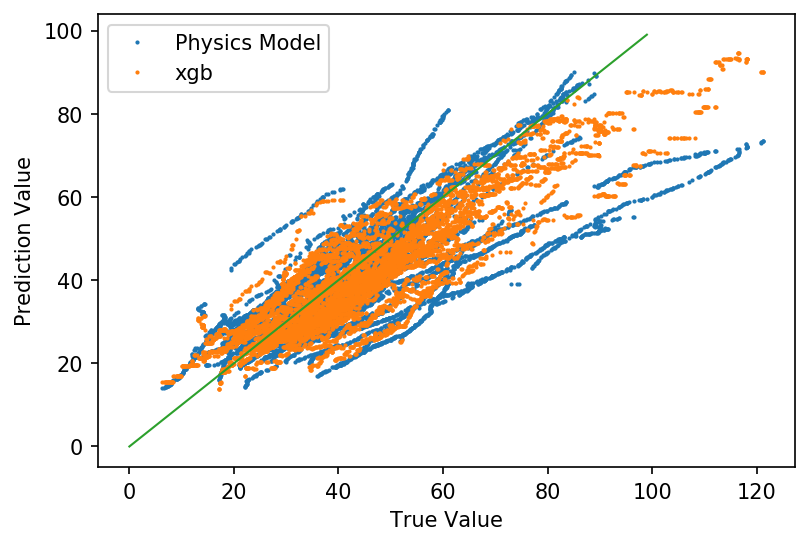

In [48]:
plt.plot(y_true, y_phy,lineStyle='none',marker='o',markersize=1,label='Physics Model')
plt.plot(y_true,y_gbm,lineStyle='none',marker='o',markersize=1, label='xgb')
plt.plot(list(range(0,100)),list(range(0,100)),linewidth=1)
plt.legend()
plt.xlabel('True Value')
plt.ylabel('Prediction Value')

In [49]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
latlon = np.transpose(np.concatenate(([sampled_df2.lat.values],[sampled_df2.lon]),axis=0))
latlon_original=np.transpose(np.concatenate(([df.LatDegree.values],[df.LongDegree.values]),axis=0))

neigh.fit(latlon_original)
distances = neigh.kneighbors(latlon)

In [50]:
sampled_df2.insert(12, 'distance', distances[0]*110.567)

In [51]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest,physics_pred,gbm_pred,dnn_pred,rf_pred,distance
0,46230,4701900241,880,35.194444,38.113789,-80.984939,38.920901,17296,26.8,34.131718,33.211952,33.141287,11.034576
1,169607,4705900811,1510,41.466667,37.572413,-81.844652,49.347069,20168,51.0,50.678089,50.092697,50.677230,1.778701
2,304982,4707700099,1220,26.088889,39.267533,-79.561792,32.027206,19021,54.9,51.897446,40.864529,50.140974,6.991075
3,434789,4706100370,670,25.322222,39.668611,-79.973694,27.699802,18967,24.7,27.010910,26.585238,25.047843,5.119747
4,424605,4709100138,890,31.444444,39.338962,-80.177553,35.277222,19578,26.3,30.527145,30.975018,28.690083,0.987929
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,556582,4709501963,1560,52.211111,39.518877,-81.018447,60.393086,19701,61.2,52.097004,51.712303,48.848777,0.010229
9996,567575,4710300645,870,24.288889,39.678222,-80.823766,27.946287,20065,27.2,25.087847,23.518005,25.688550,0.375988
9997,355526,4708300103,1320,56.611111,38.707282,-79.969042,63.243988,19185,36.7,39.591377,41.611328,39.358590,12.912729
9998,330733,4707700458,2280,64.250000,39.523952,-79.615534,77.115038,19054,77.9,77.103699,74.020546,76.826878,1.207868


In [52]:
sampled_df2
sampled_df2['avgd_model'] = sampled_df2[['physics_pred', 'gbm_pred', 'dnn_pred']].mean(axis=1)

In [53]:
sampled_df2

,index,id,depth,temp,lat,lon,corrtemp,closest,physics_pred,gbm_pred,dnn_pred,rf_pred,distance,avgd_model
0,46230,4701900241,880,35.194444,38.113789,-80.984939,38.920901,17296,26.8,34.131718,33.211952,33.141287,11.034576,31.381223
1,169607,4705900811,1510,41.466667,37.572413,-81.844652,49.347069,20168,51.0,50.678089,50.092697,50.677230,1.778701,50.590262
2,304982,4707700099,1220,26.088889,39.267533,-79.561792,32.027206,19021,54.9,51.897446,40.864529,50.140974,6.991075,49.220658
3,434789,4706100370,670,25.322222,39.668611,-79.973694,27.699802,18967,24.7,27.010910,26.585238,25.047843,5.119747,26.098716
4,424605,4709100138,890,31.444444,39.338962,-80.177553,35.277222,19578,26.3,30.527145,30.975018,28.690083,0.987929,29.267388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,556582,4709501963,1560,52.211111,39.518877,-81.018447,60.393086,19701,61.2,52.097004,51.712303,48.848777,0.010229,55.003102
9996,567575,4710300645,870,24.288889,39.678222,-80.823766,27.946287,20065,27.2,25.087847,23.518005,25.688550,0.375988,25.268617
9997,355526,4708300103,1320,56.611111,38.707282,-79.969042,63.243988,19185,36.7,39.591377,41.611328,39.358590,12.912729,39.300902
9998,330733,4707700458,2280,64.250000,39.523952,-79.615534,77.115038,19054,77.9,77.103699,74.020546,76.826878,1.207868,76.341415


/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


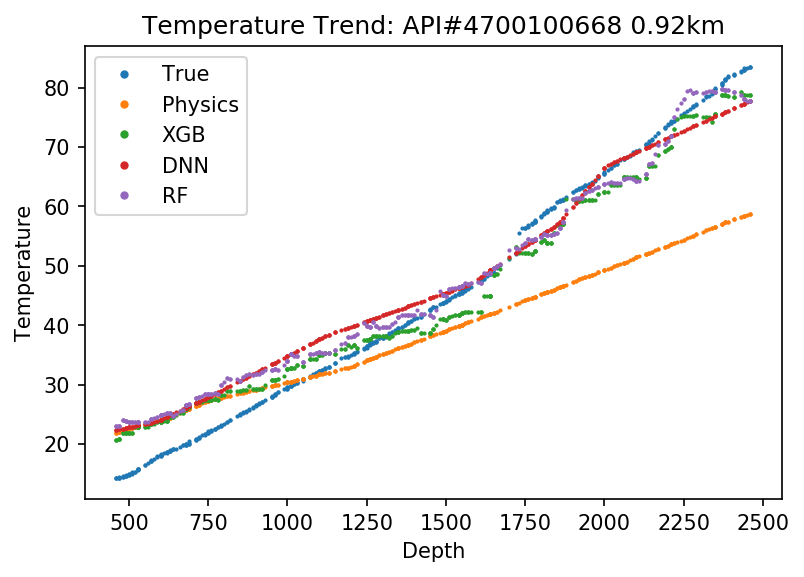

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


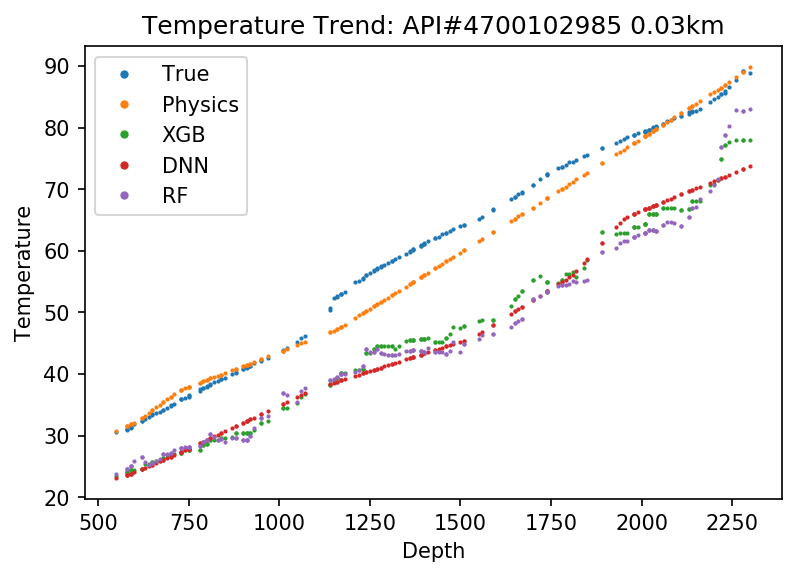

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


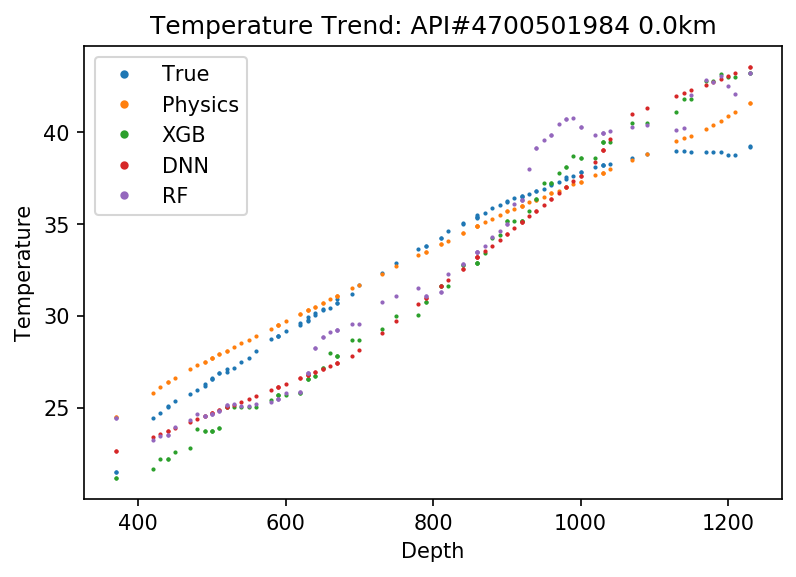

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


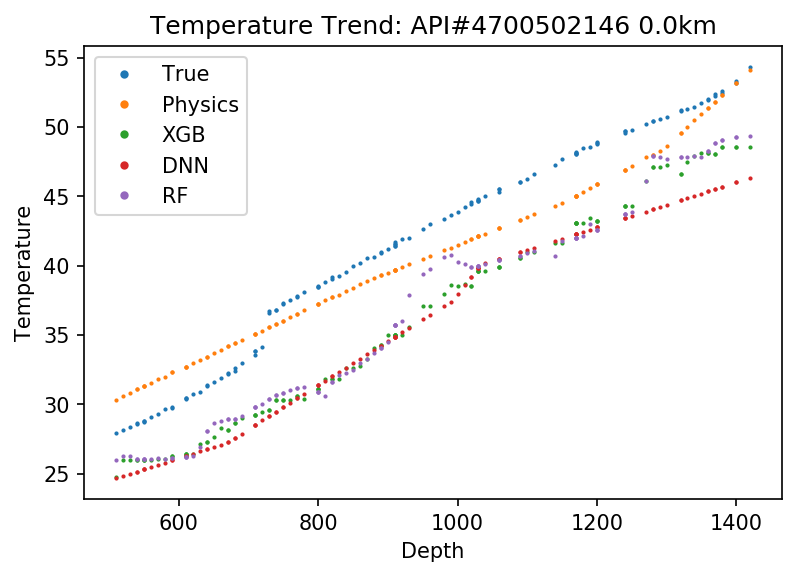

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


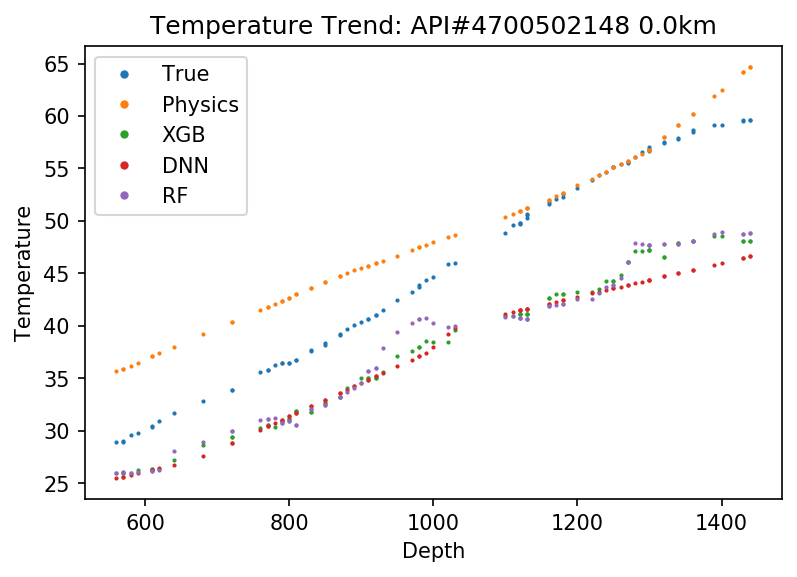

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


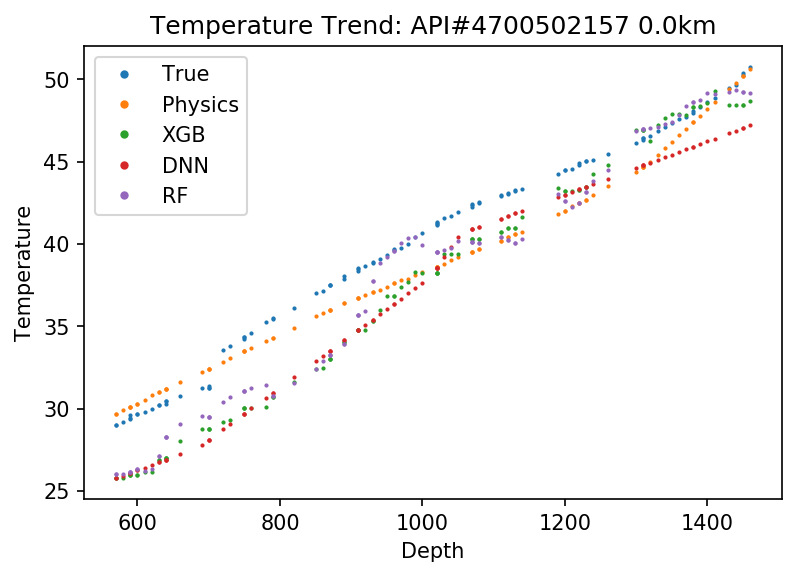

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


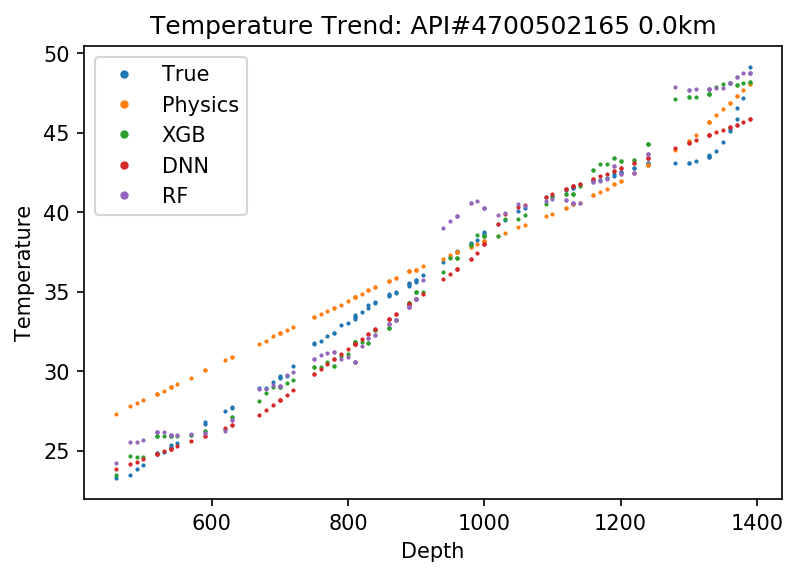

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


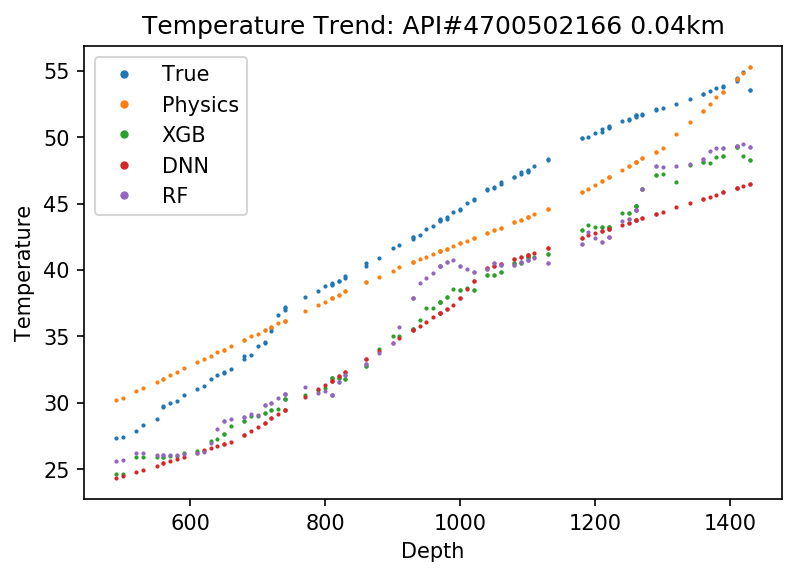

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


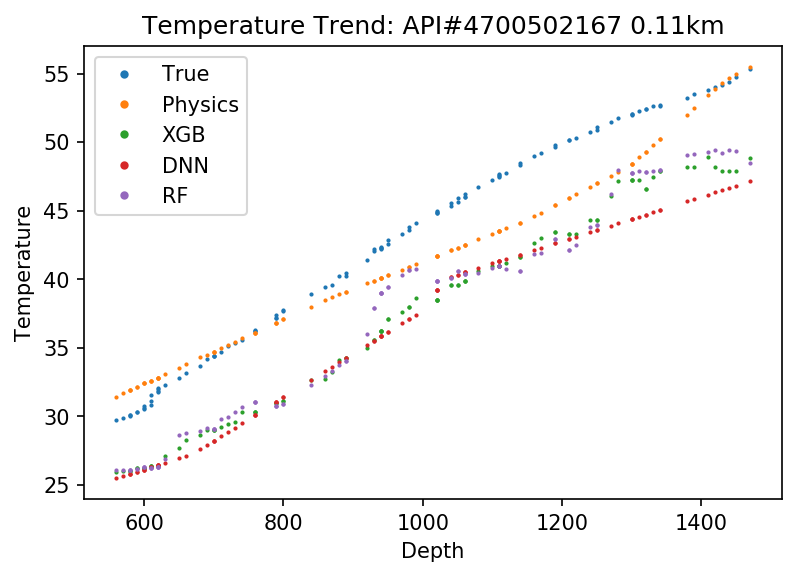

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


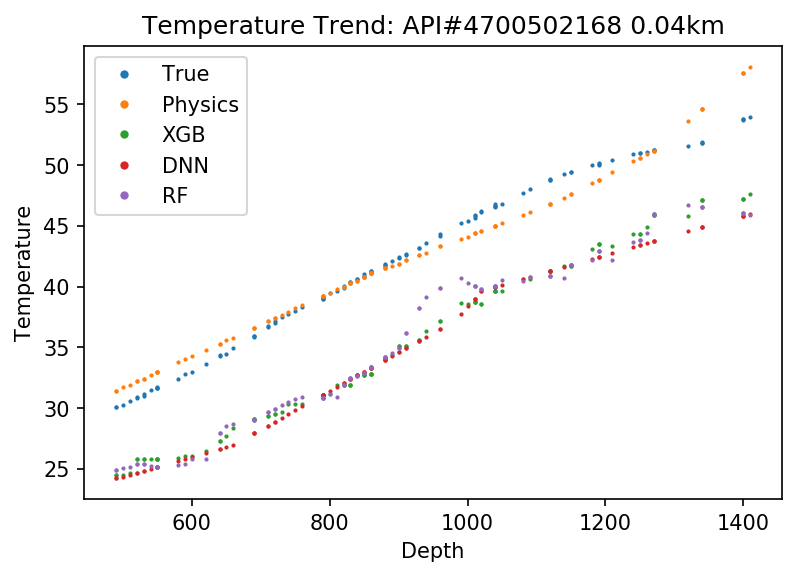

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


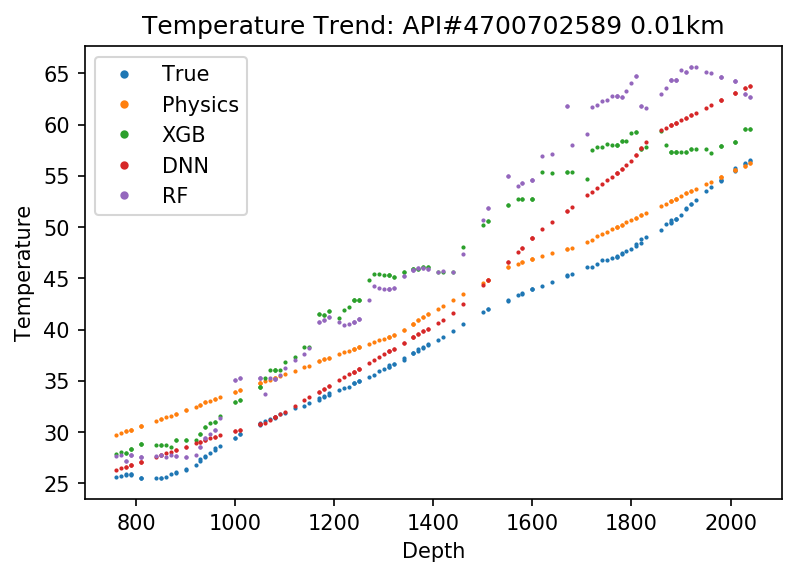

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


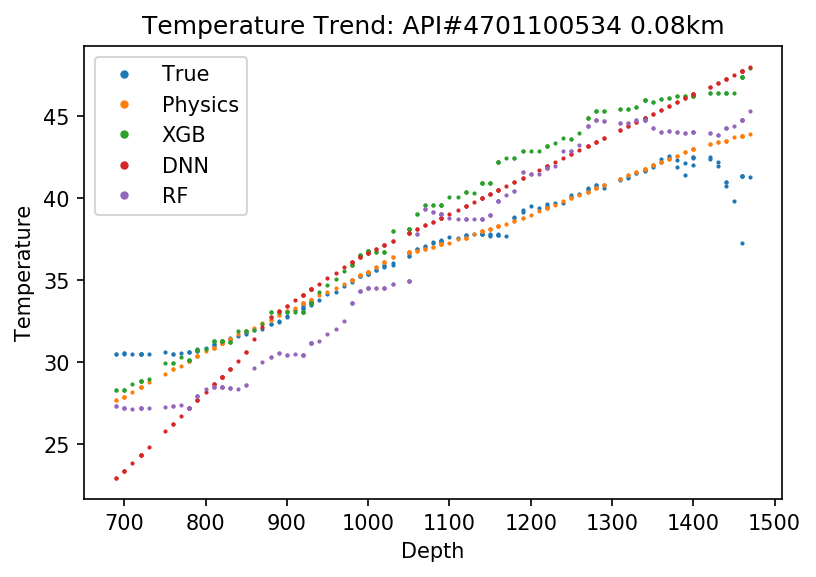

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


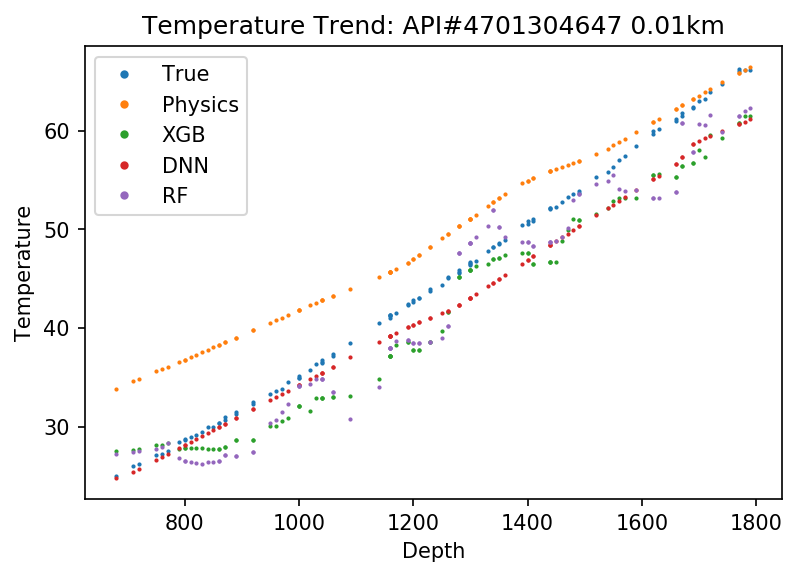

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


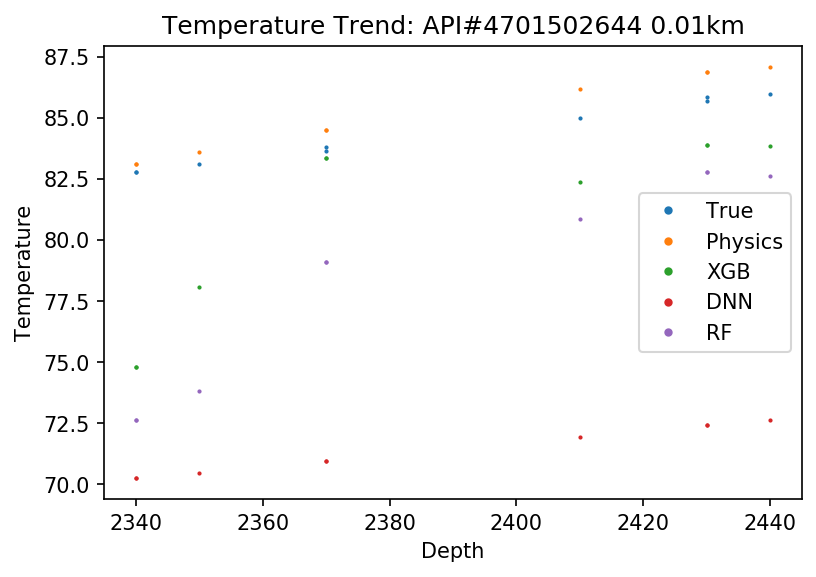

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


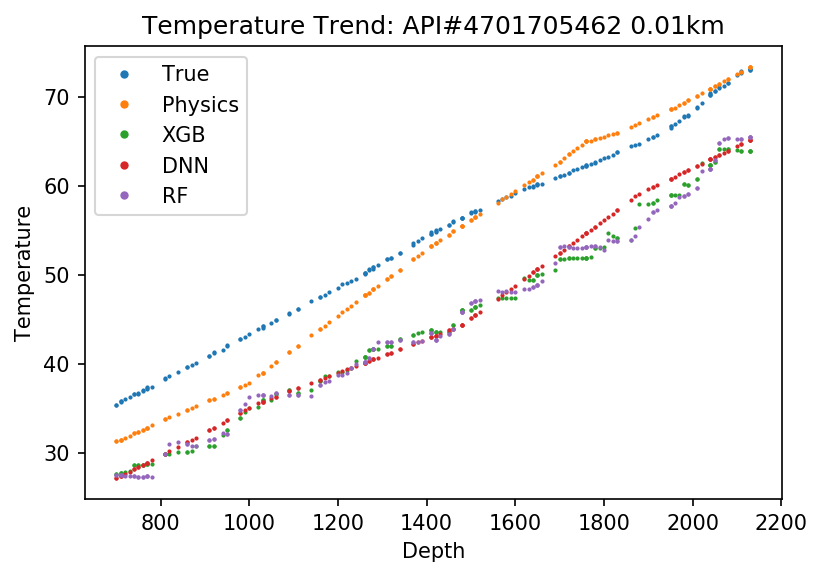

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


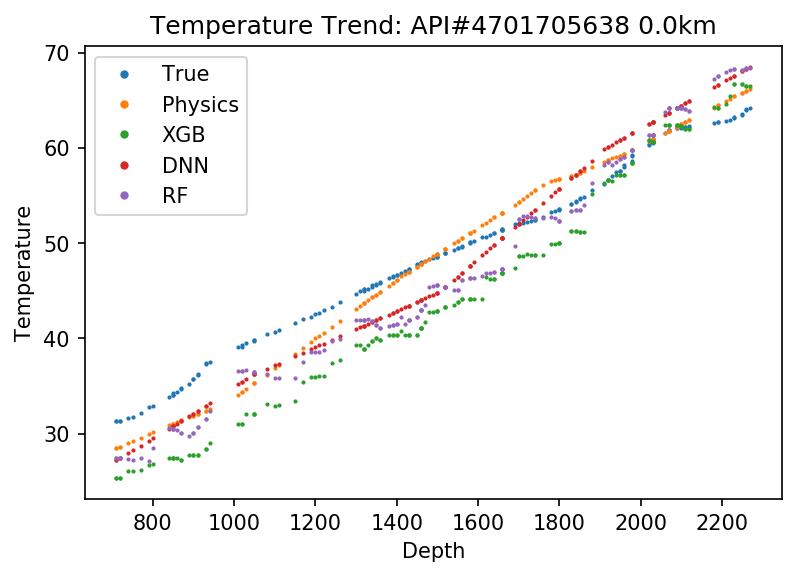

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


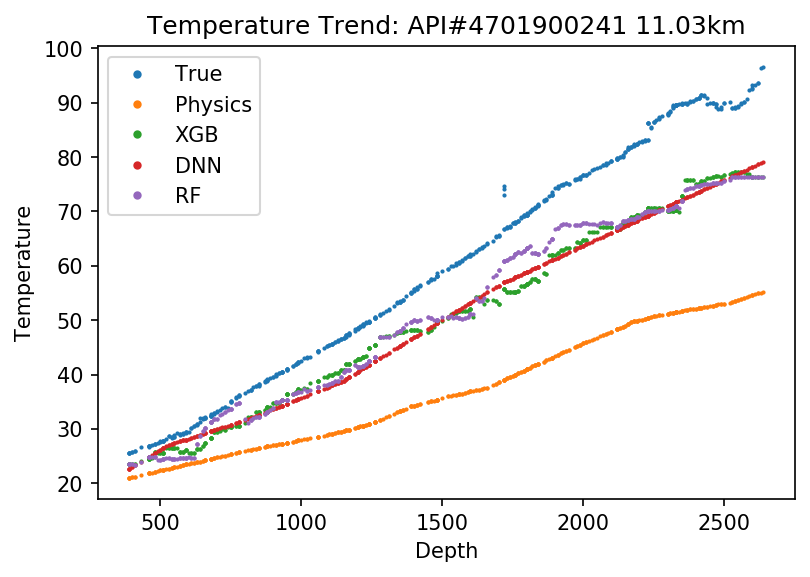

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


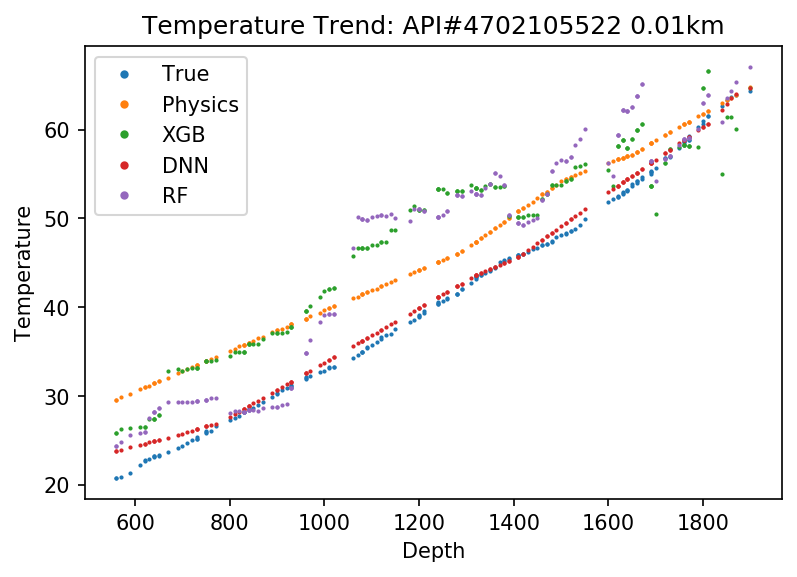

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


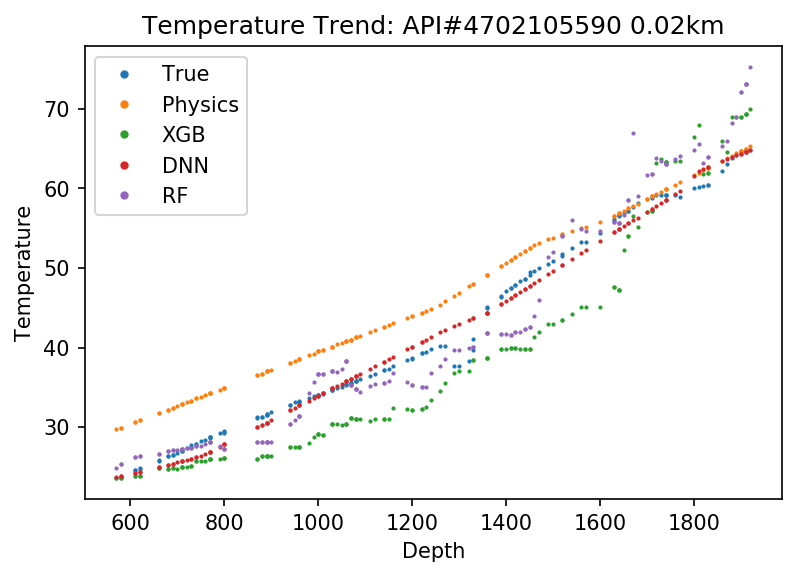

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


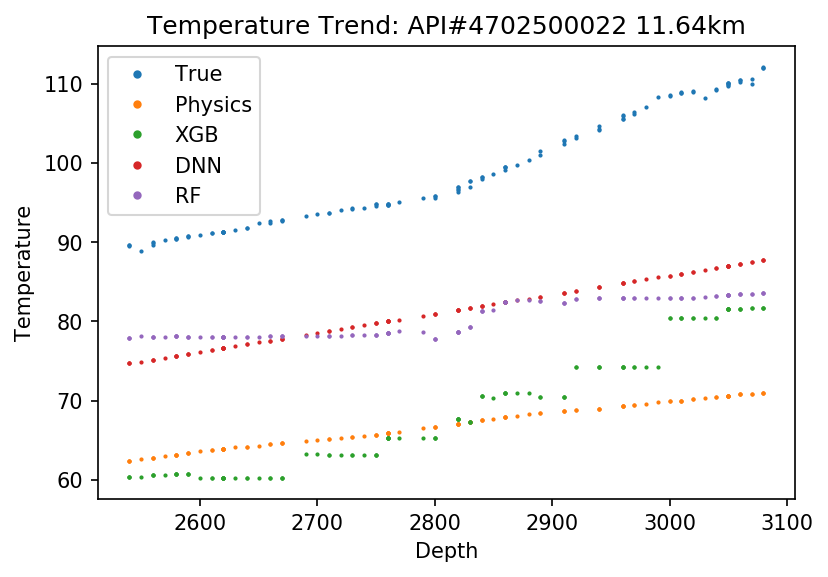

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


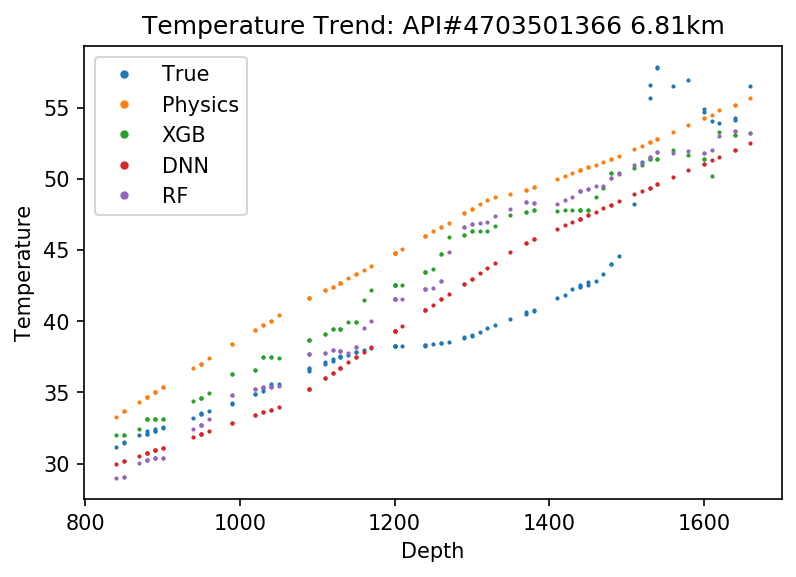

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


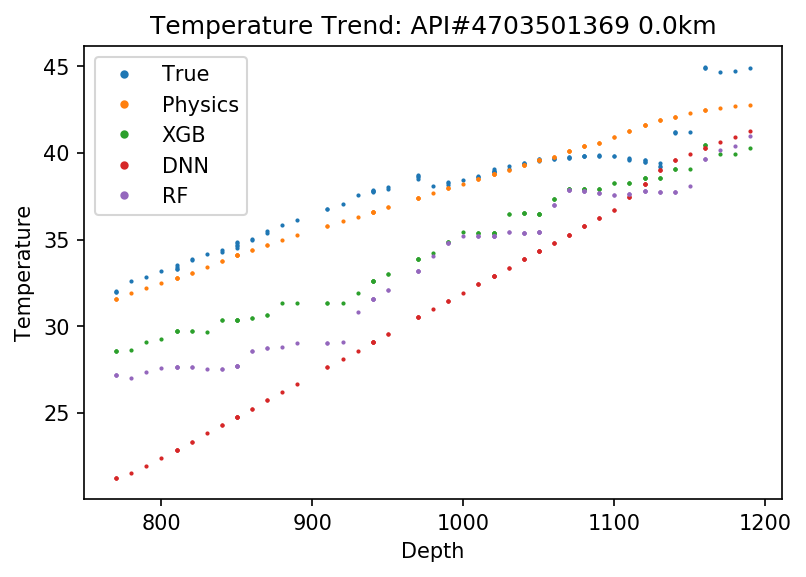

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


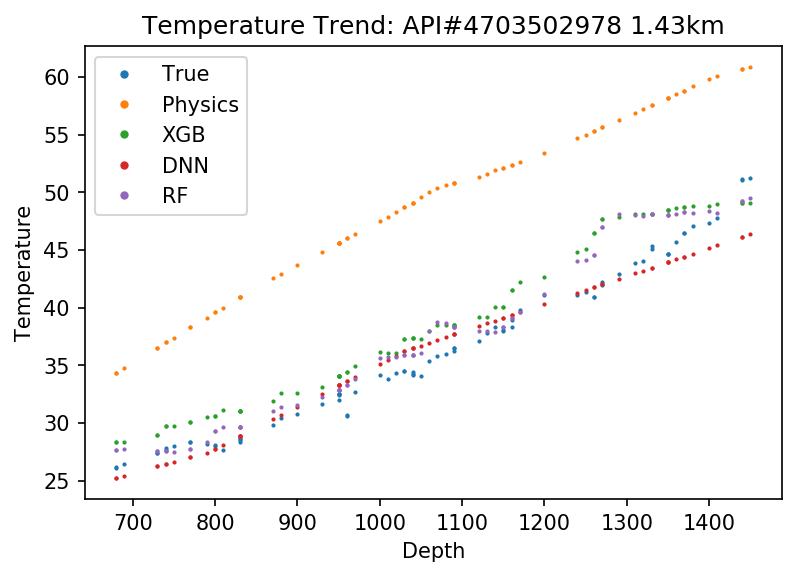

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


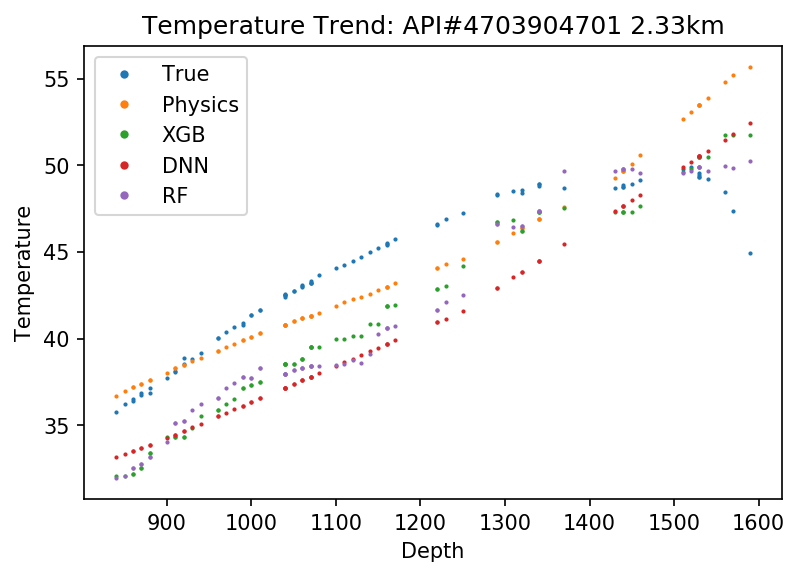

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


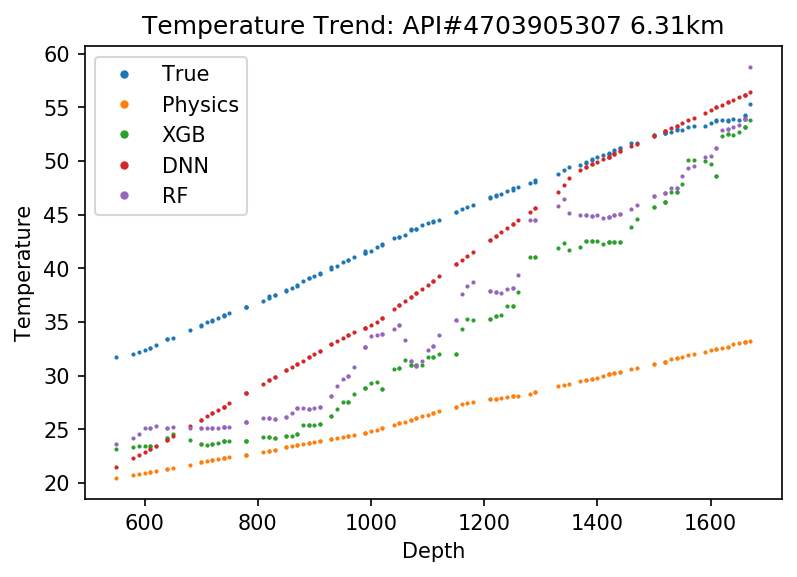

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


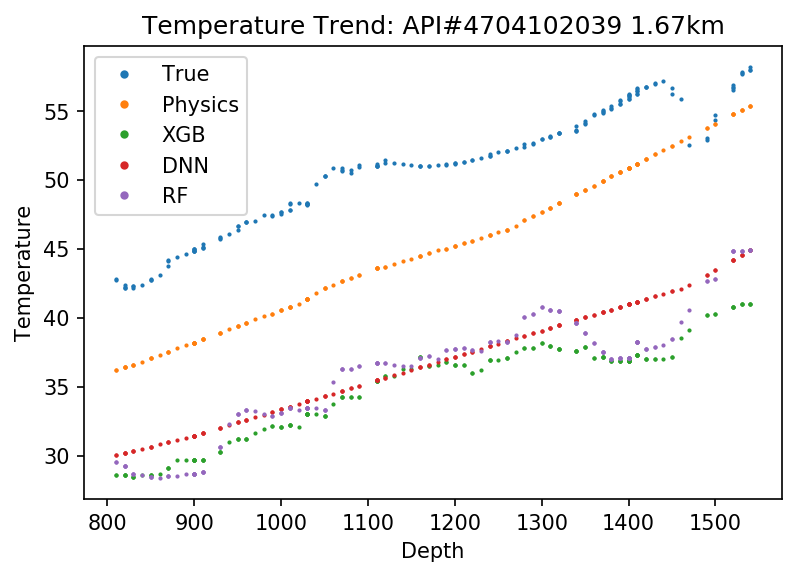

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


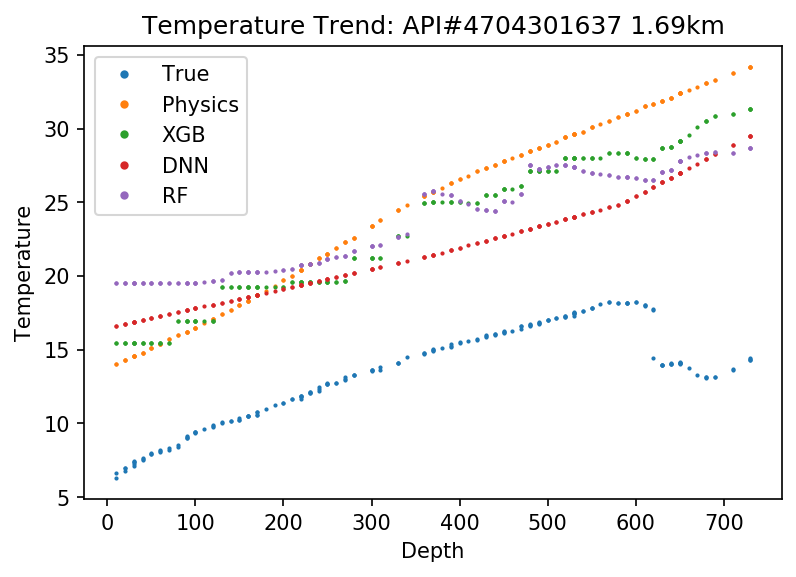

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


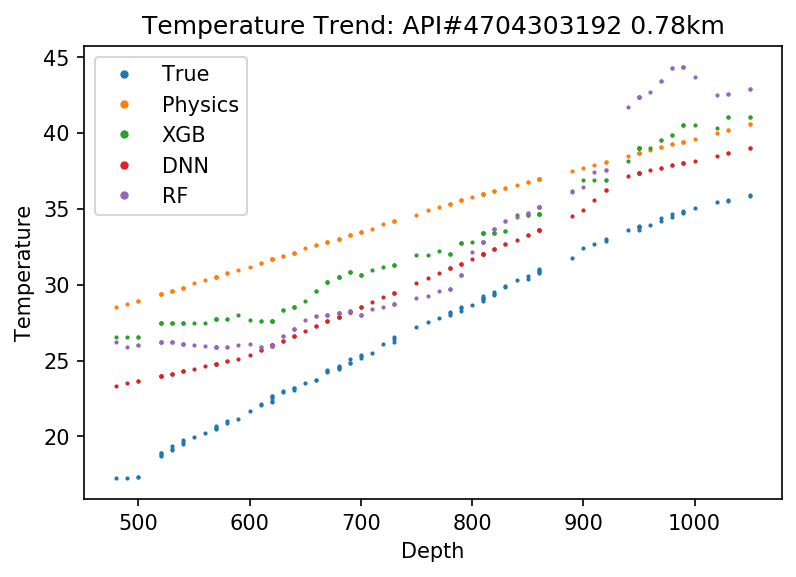

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


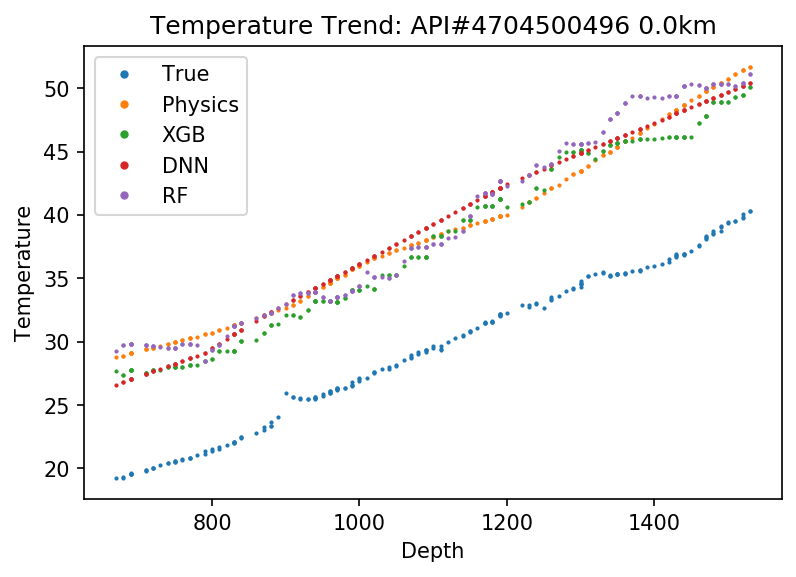

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


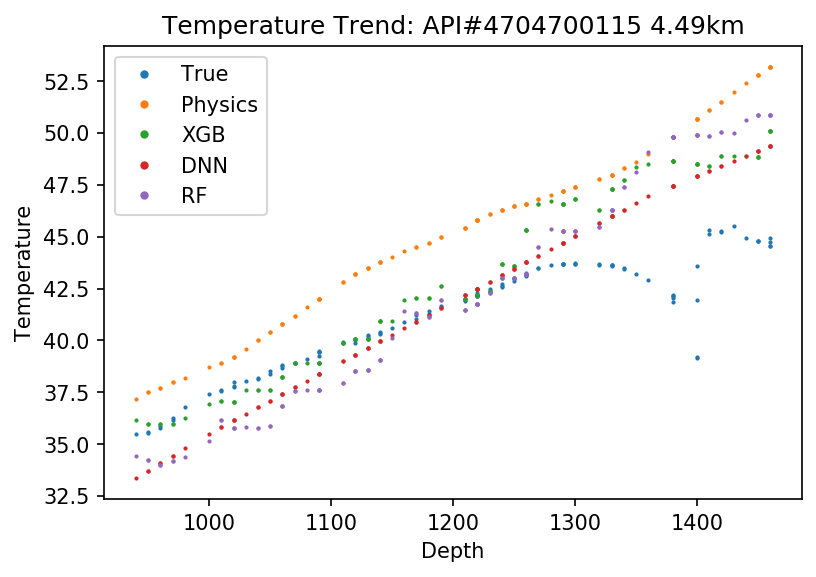

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


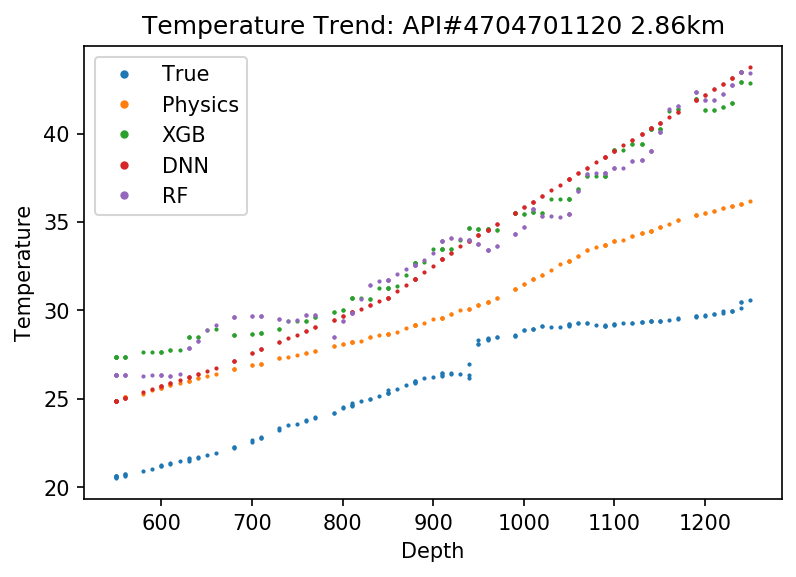

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


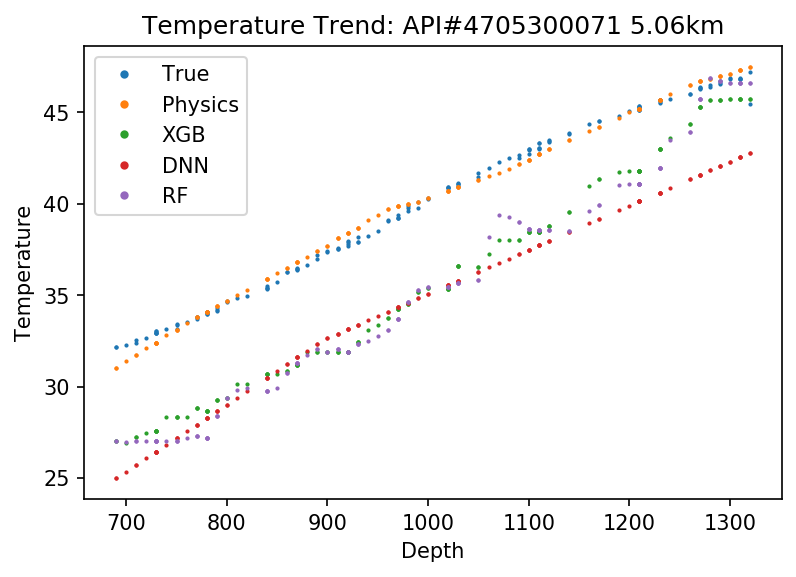

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


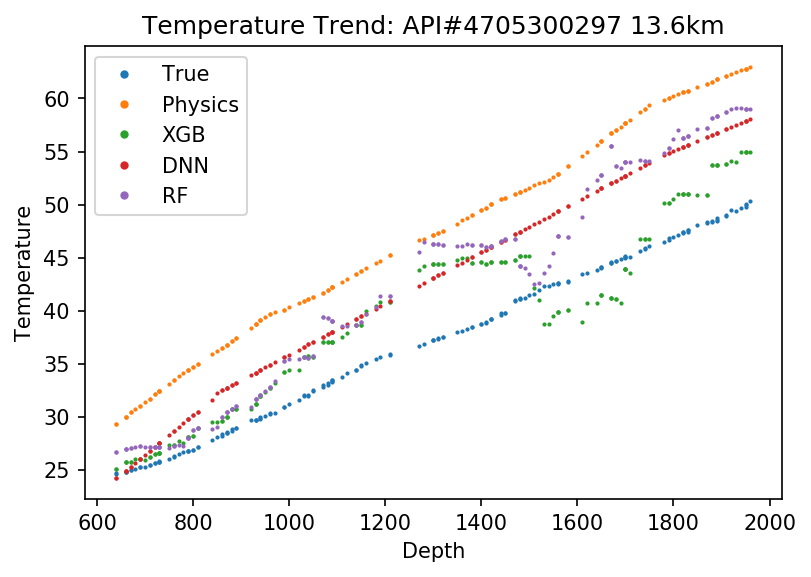

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


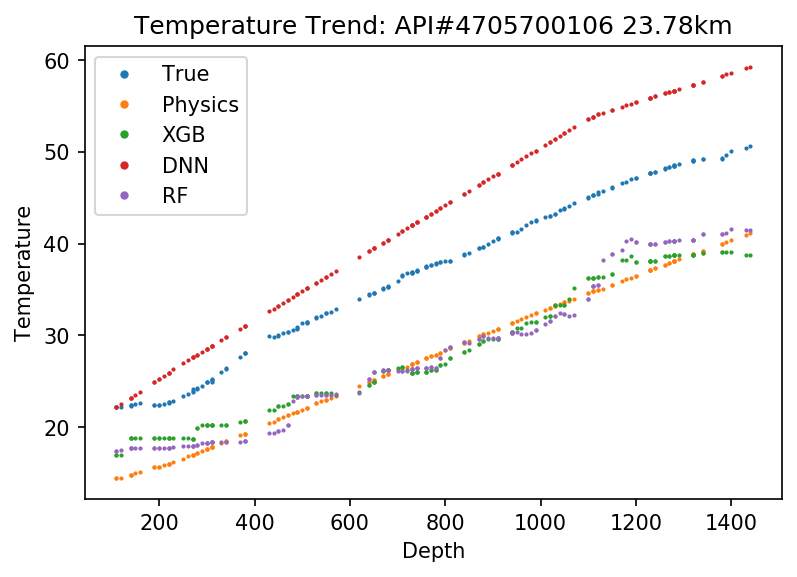

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


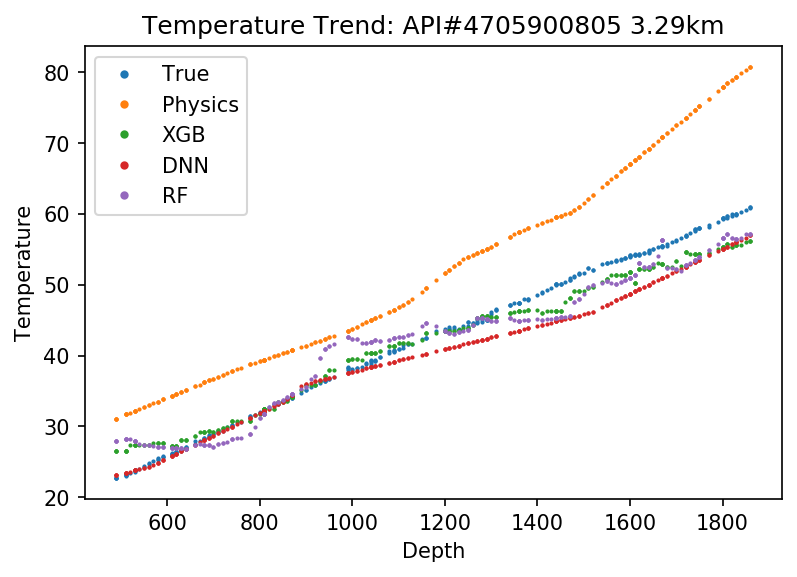

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


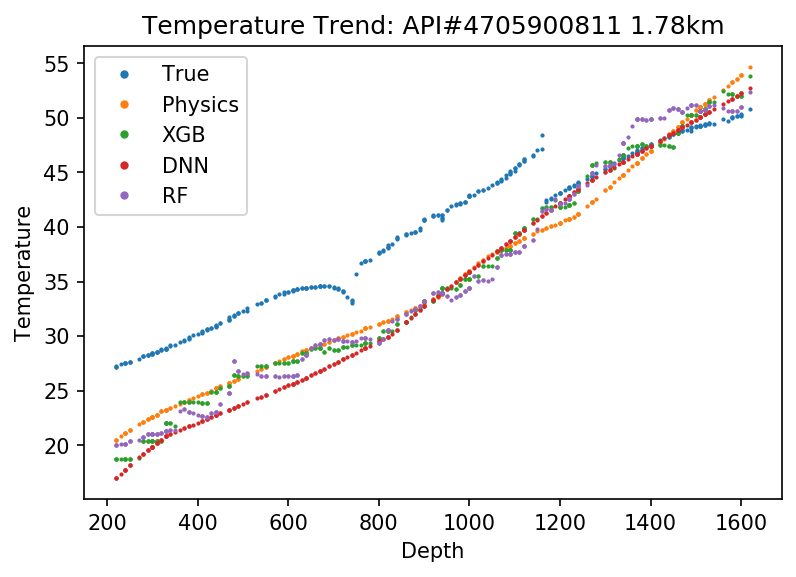

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


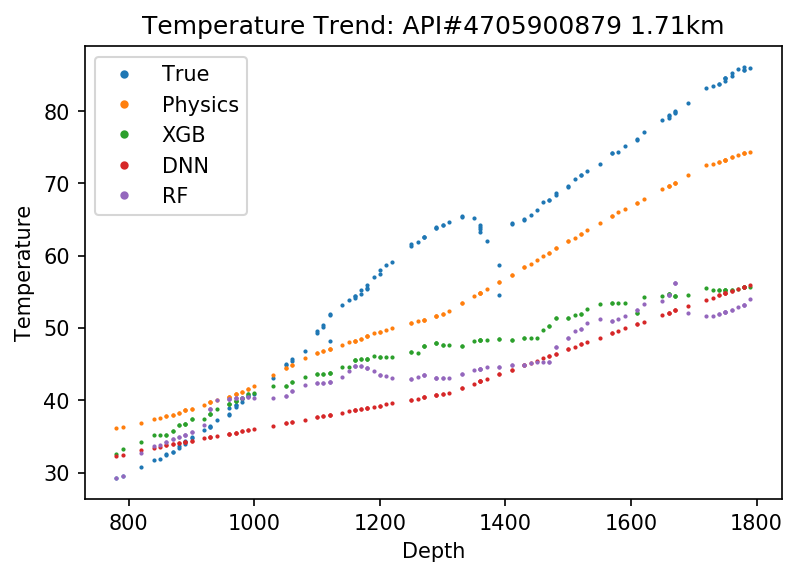

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


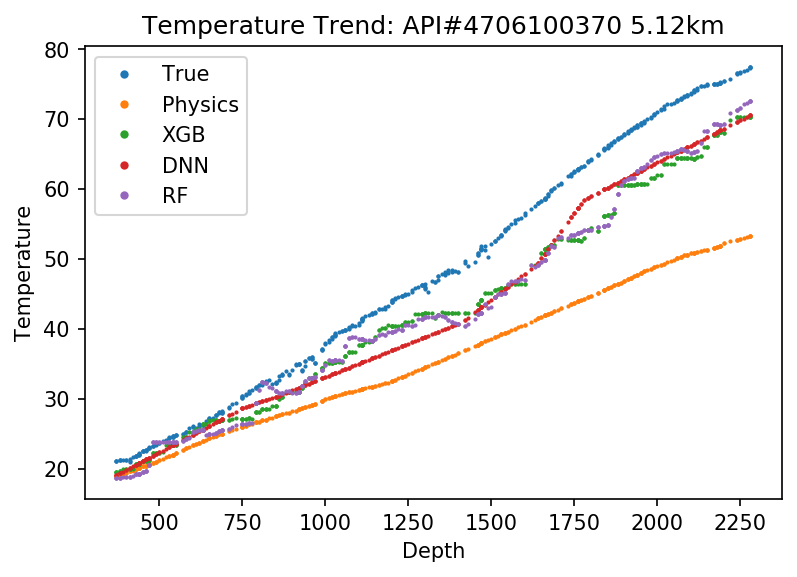

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


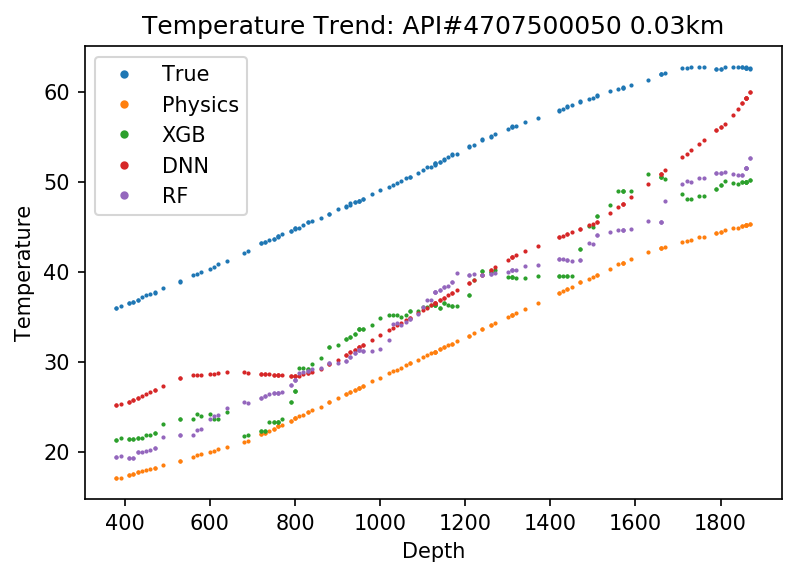

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


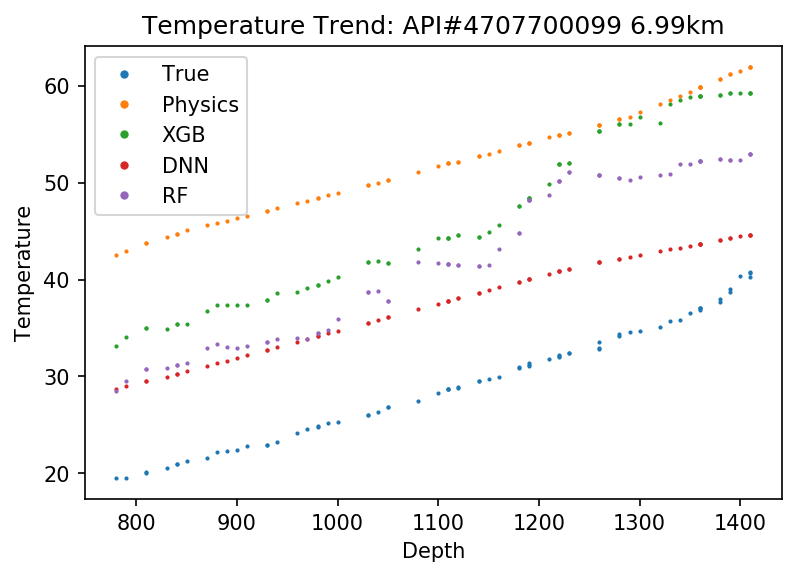

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


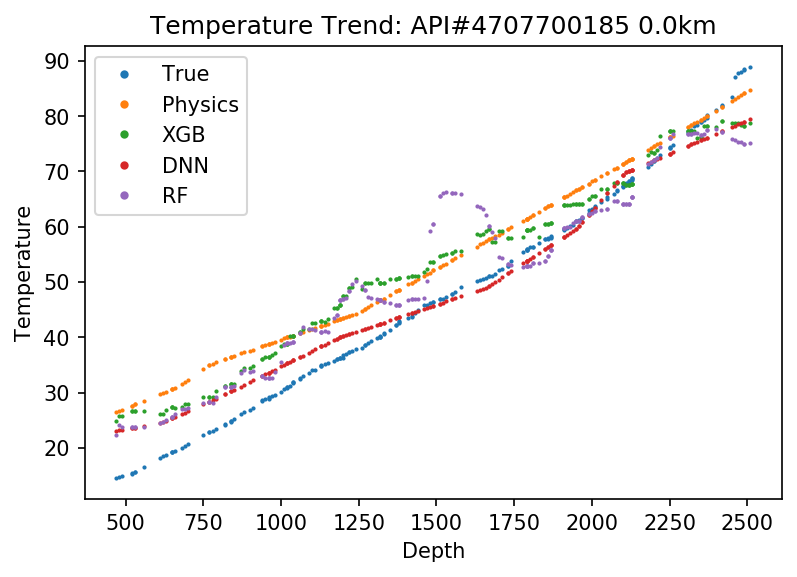

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


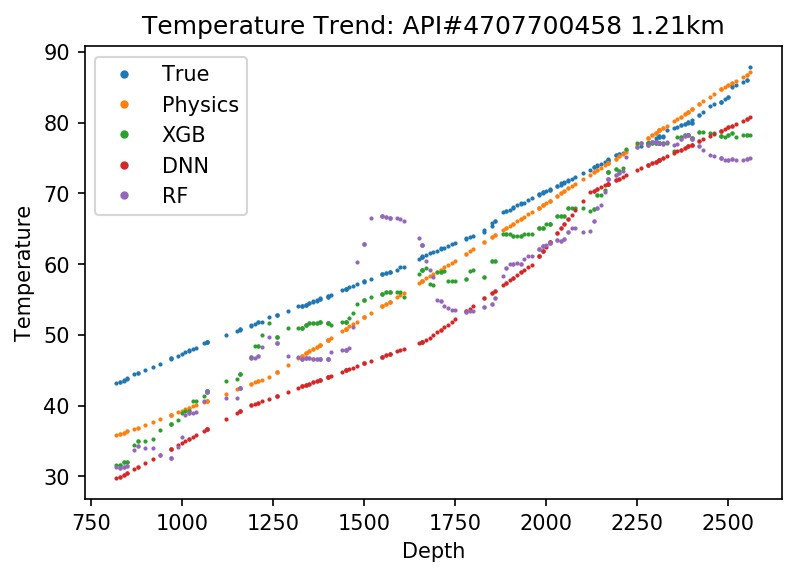

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


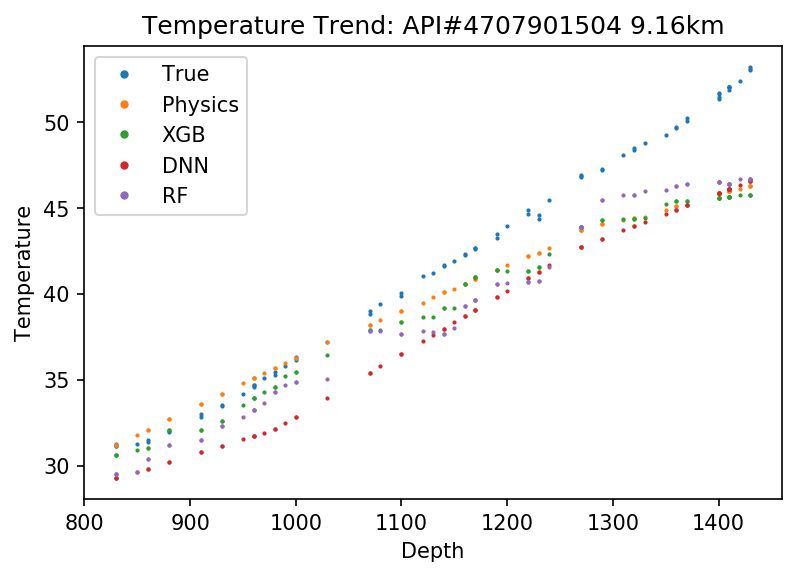

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


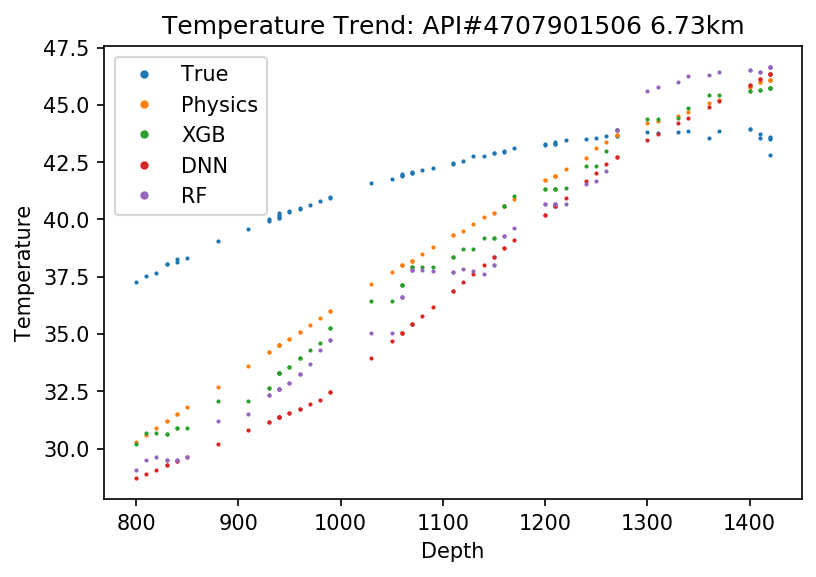

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


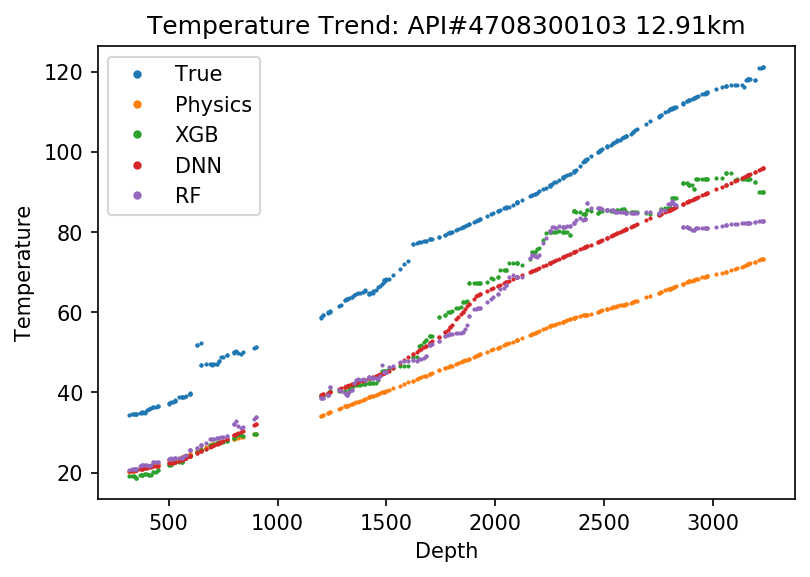

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


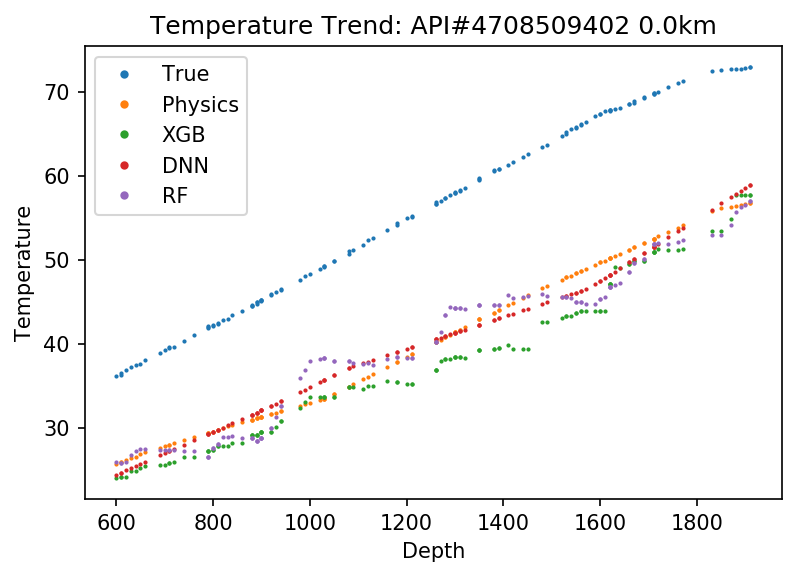

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


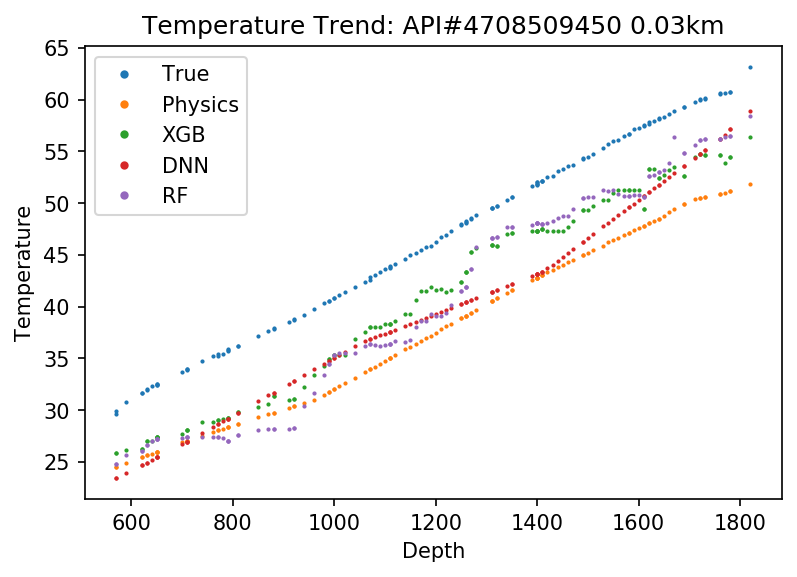

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


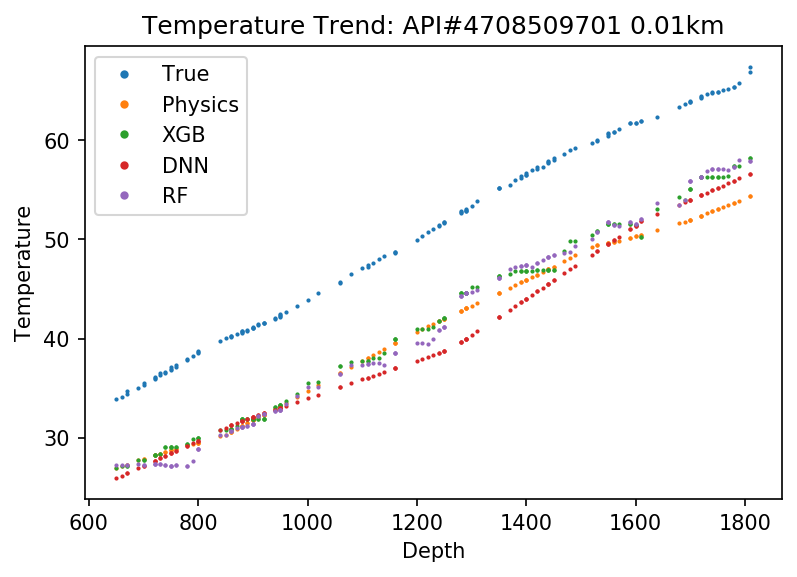

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


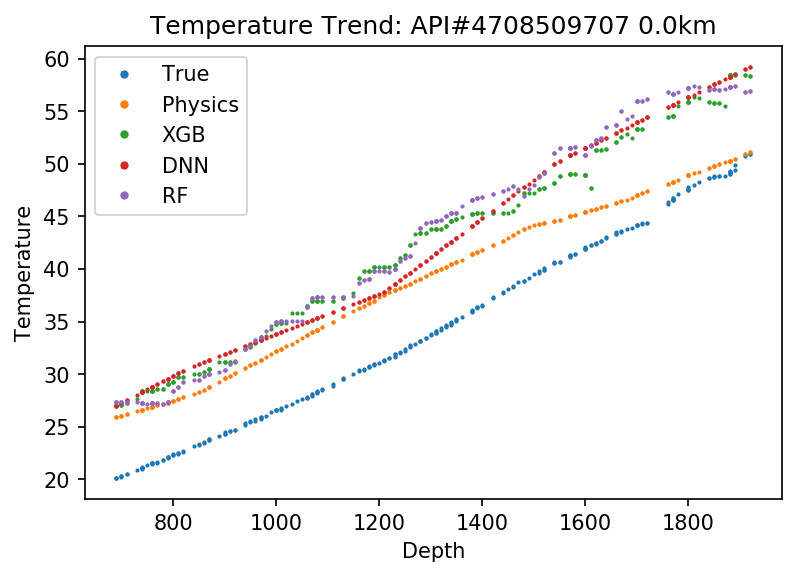

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


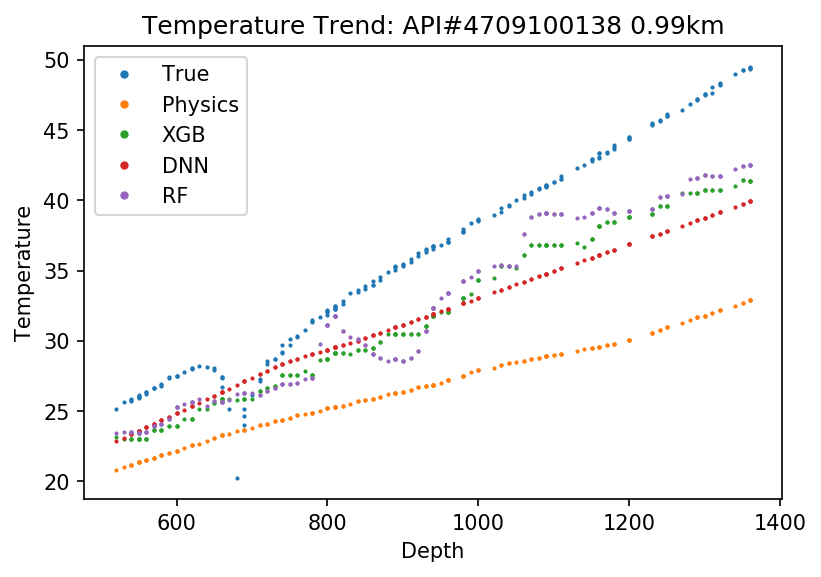

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


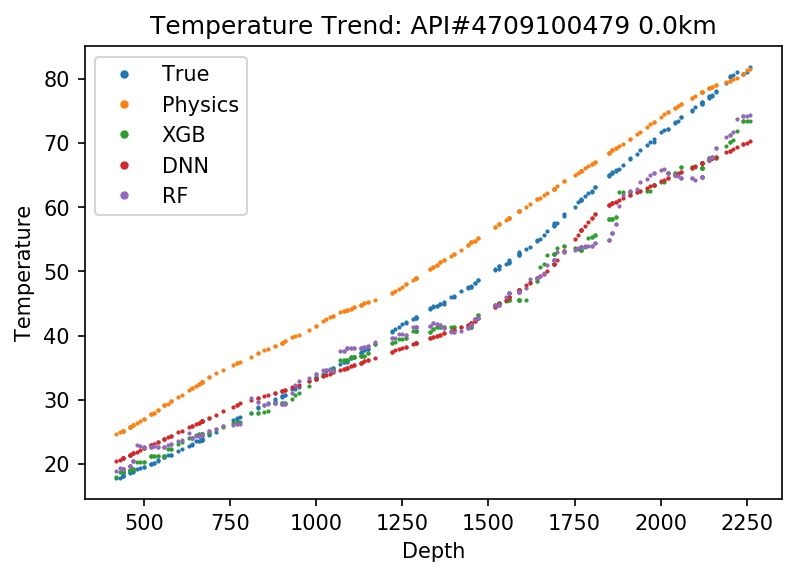

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


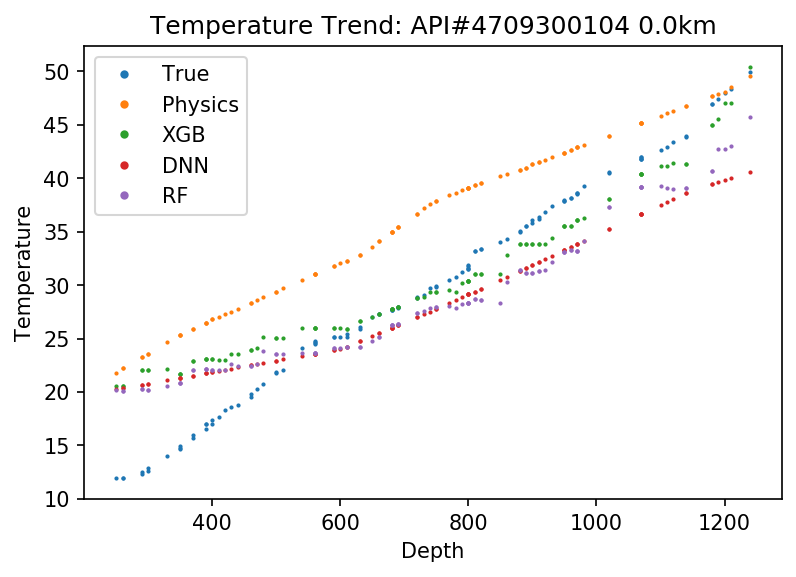

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


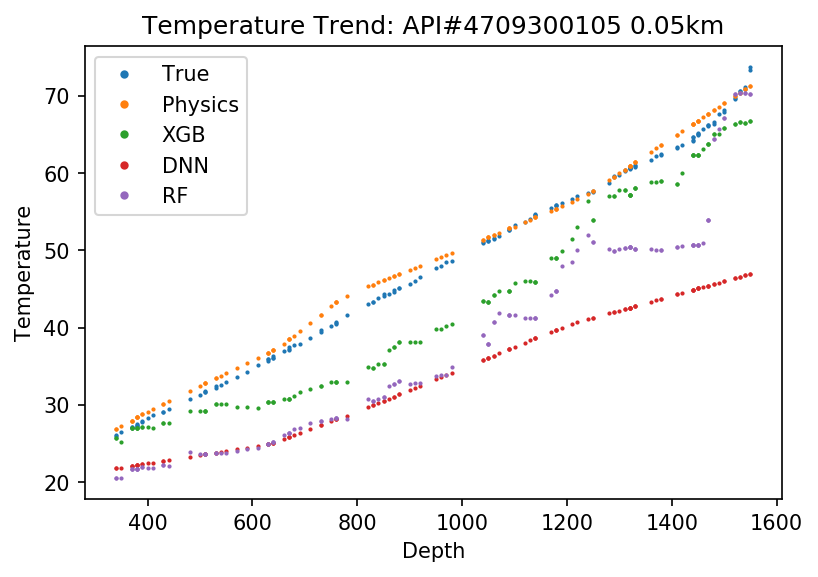

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


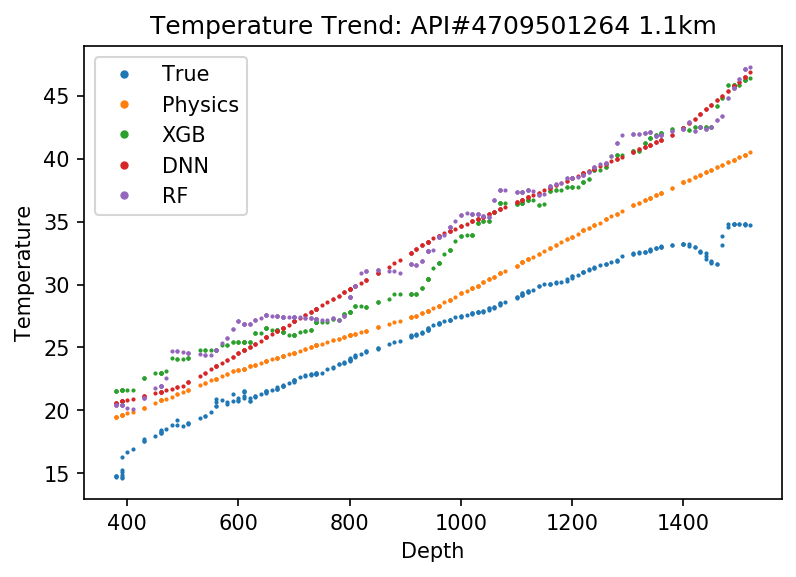

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


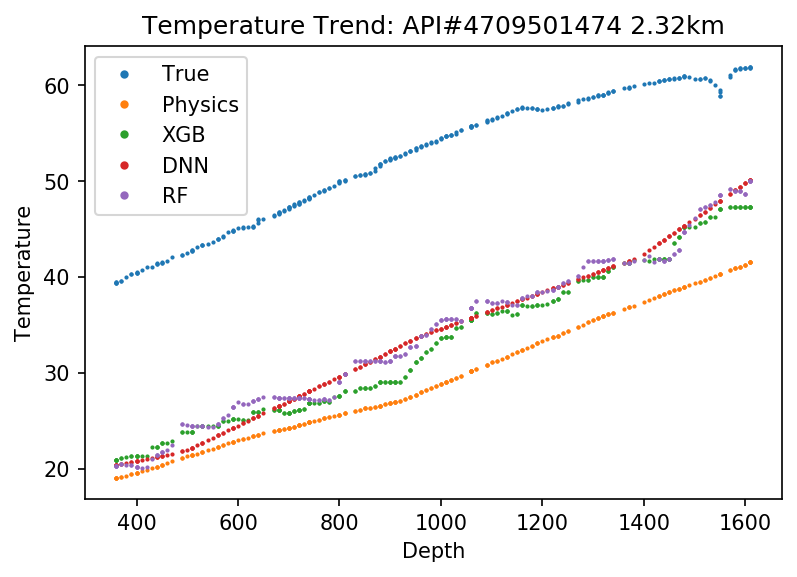

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


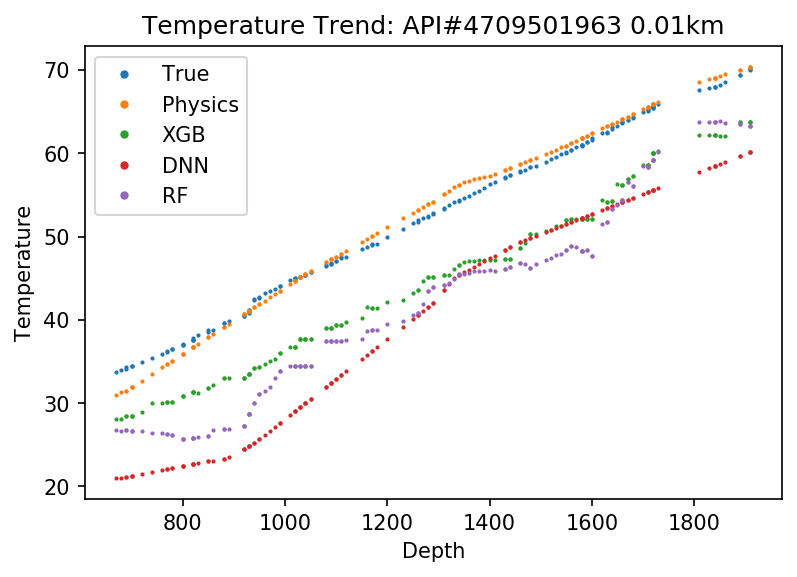

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


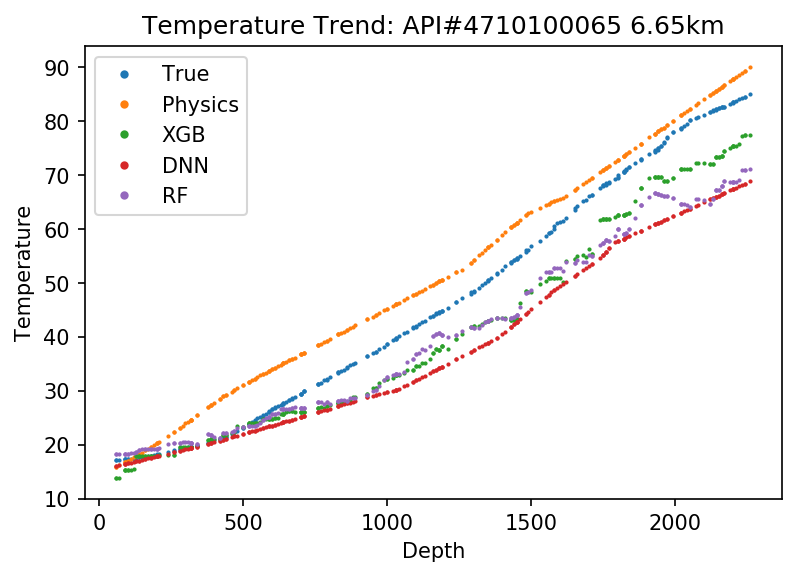

/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/aryashahdi/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


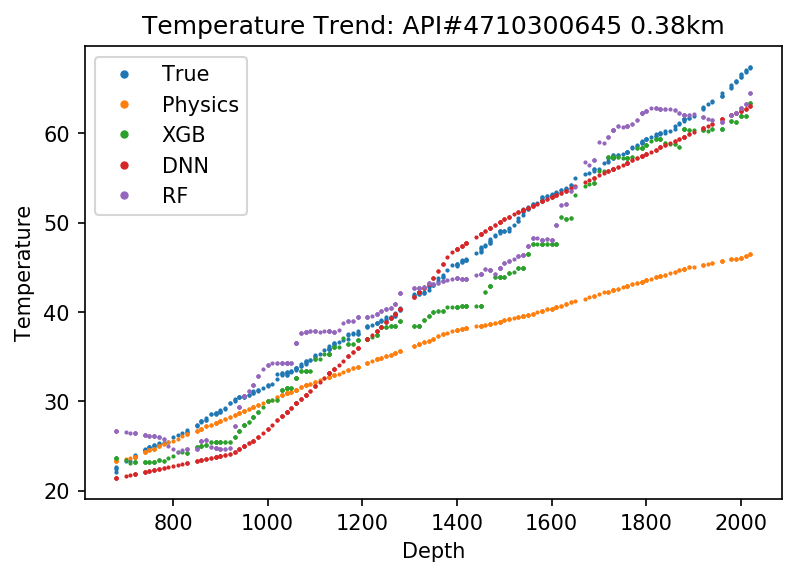

In [55]:
for curr_id in np.unique(sampled_df2.id):
    ms = 2
    y_true = sampled_df2[sampled_df2.iloc[:,1]==curr_id]['corrtemp']
    y_physics = sampled_df2[sampled_df2.iloc[:,1]==curr_id]['physics_pred']
    y_gbm = sampled_df2[sampled_df2.iloc[:,1]==curr_id]['gbm_pred']
    y_dnn = sampled_df2[sampled_df2.iloc[:,1]==curr_id]['dnn_pred']
    y_rf = sampled_df2[sampled_df2.iloc[:,1]==curr_id]['rf_pred']
#     y_avgd = sampled_df2[sampled_df2.iloc[:,1]==curr_id]['avgd_model']
    depth_hat = sampled_df2[sampled_df2.iloc[:,1]==curr_id]['depth']
    plt.plot(depth_hat,y_true, lineStyle='none',marker='.',markersize=ms, label='True')
    plt.plot(depth_hat,y_physics,lineStyle='none',marker='.',markersize=ms, label= 'Physics')
    plt.plot(depth_hat,y_gbm,lineStyle='none',marker='.',markersize=ms, label='XGB')
    plt.plot(depth_hat,y_dnn,lineStyle='none',marker='.',markersize=ms, label='DNN')
    plt.plot(depth_hat, y_rf, lineStyle='none', marker='.', markersize=ms, label='RF')
#     plt.plot(depth_hat,y_avgd,lineStyle='none',marker='.',markersize=ms, label='Ensemble')

    lgd = plt.legend()
    lgd.legendHandles[0]._legmarker.set_markersize(6)
    lgd.legendHandles[1]._legmarker.set_markersize(6)
    lgd.legendHandles[2]._legmarker.set_markersize(6)
    lgd.legendHandles[3]._legmarker.set_markersize(6)
    lgd.legendHandles[4]._legmarker.set_markersize(6)
    plt.xlabel('Depth')
    plt.ylabel('Temperature')
    curr_dist = sampled_df2[sampled_df2.id==curr_id].distance.values[0]
    plt.title('Temperature Trend: API#'+str(curr_id) + ' '+str(round(curr_dist,2)) + 'km')
    plt.show()

# RF Accuracy with only Original DF

In [59]:
rf = RandomForestRegressor(max_depth = 9)
X = np.transpose(np.array([df.LatDegree,
                                df.LongDegree,
                                df.MeasureDepth_m,
                                df.SurfTemp]))
X = np.concatenate((X, mult),axis=1)
y = df.CorrBHT

NameError: name 'RandomForestRegressor' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=int(100*np.random.random()))
rf.fit(X_train, y_train)
np.mean(abs(y_test - rf.predict(X_test)))

In [ ]:
3*np.std(df.MeasureDepth_m)

In [ ]:
np.mean(df.MeasureDepth_m)

In [ ]:
thresh = np.mean(df.MeasureDepth_m) + 4*np.std(df.MeasureDepth_m)

In [ ]:
np.min(df.MeasureDepth_m[df.MeasureDepth_m > thresh])

In [ ]:
df.MeasureDepth_m[df.MeasureDepth_m > thresh]

In [ ]:
depth_range = []
df2size = df2['id'].unique().shape[0]
for api_ind in df2['id'].unique():
    mask = df2['id'] == api_ind
    min_depth = min(df2[mask].loc[:,'depth'])
    max_depth = max(df2[mask].loc[:,'depth'])
    depth_range.append(max_depth-min_depth)

In [ ]:
len(depth_range)

In [ ]:
np.std(depth_range)

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200
fig, ax = plt.subplots()
ax.scatter(df.LongDegree, df.LatDegree, s=1, alpha=0.5, c=np.array([[1.0, 0.55, 0.20]]))
ax.scatter(df2.lon, df2.lat, s=5,c='blue',marker='o')
plt.xlim(-85,-77.5)
plt.ylim(37,40)
#for i, txt in enumerate(well_id_last_digits):
#    ax.annotate(txt, (df2.lat[i], df2.lon[i]),size=5)

plt.xlabel('Longitude',fontsize=12)
plt.ylabel('Latitude',fontsize=12)
plt.show()